### Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from feature_engine.imputation import CategoricalImputer, DropMissingData
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from feature_engine.wrappers import SklearnTransformerWrapper
from catboost import CatBoostClassifier
import optuna
import lightgbm as lgb
from optuna.integration import LightGBMPruningCallback
import warnings

warnings.filterwarnings(action='ignore')

c:\Users\aashi\Desktop\Personal Projects\Data Science\Identifying-Faulty-Water-Pumps-With-Machine-Learning\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_values = pd.read_csv('data/train_values.csv')
train_label = pd.read_csv('data/train_labels.csv')

In [3]:
# merge the two data frames
df = train_values.merge(train_label, on='id')

In [4]:
# check that all rows were in the joined dataset
len(df) == len(train_label) == len(train_values)

True

In [5]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [6]:
# search for duplicates 
df[df['id'].duplicated()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group


In [7]:
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['column', 'number of missing values']
missing[missing['number of missing values']>0]

,column,number of missing values
3,funder,3637
5,installer,3655
8,wpt_name,2
11,subvillage,371
18,public_meeting,3334
20,scheme_management,3878
21,scheme_name,28810
22,permit,3056


### Remove Unwanted Fields

In [8]:
# uneeded columns (fields that don't help predict the target label)
unneeded_col = ['id', 'recorded_by', 'wpt_name']
df = df.drop(unneeded_col, axis=1)



### Handling Fields with Too Many Unique Values

In [9]:
# get all categorical variables
df['region_code'] = df['region_code'].astype('object')
df['district_code'] = df['district_code'].astype('object')

cat_var = [col for col in df.columns if df[col].dtypes == 'object']
col_count = {}

# find number of unique values in each categorical variable
for col in cat_var:
    count = df[col].nunique()
    col_count[col] = count
col_count_df = pd.DataFrame(col_count.items())
col_count_df.columns = ['Field', 'Number of Unique Values']
col_count_df.head()

,Field,Number of Unique Values
0,date_recorded,356
1,funder,1896
2,installer,2145
3,basin,9
4,subvillage,19287


In [10]:
# redundant data (fields with information provided in other columns)
redundant_col = ['subvillage','latitude', 'longitude', 'region_code', 'district_code', 'lga', 'ward', 'scheme_name', 'extraction_type', 'extraction_type_group', 'payment', 'water_quality', 'quantity', 'source', 'source_type', 'waterpoint_type', 'management']

df = df.drop(redundant_col, axis=1)

### Handle Fields with Missing Values

In [11]:
cat_var = [col for col in df.columns if df[col].dtypes == 'object']
col_count = {}

# find number of unique values in each categorical variable
for col in cat_var:
    count = df[col].nunique()
    col_count[col] = count
col_count

{'date_recorded': 356,
 'funder': 1896,
 'installer': 2145,
 'basin': 9,
 'region': 21,
 'public_meeting': 2,
 'scheme_management': 11,
 'permit': 2,
 'extraction_type_class': 7,
 'management_group': 5,
 'payment_type': 7,
 'quality_group': 6,
 'quantity_group': 5,
 'source_class': 3,
 'waterpoint_type_group': 6,
 'status_group': 3}

In [12]:
missing = pd.DataFrame(df.isnull().sum()/len(df)*100).reset_index()
missing.columns = ['column', '% missing values']
missing[missing['% missing values']>0]

,column,% missing values
2,funder,6.122896
4,installer,6.153199
9,public_meeting,5.612795
10,scheme_management,6.528620
11,permit,5.144781


### Handle Date Values

In [13]:
# derive age of water pump (i.e., years since construction)
df['construction_year'] = pd.to_datetime(df['construction_year'])
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['age'] = (df['date_recorded'] - df['construction_year']) / np.timedelta64(1, 'Y')

# delete construction_year and date_recorded columns 
df = df.drop(['construction_year', 'date_recorded'], axis=1)

In [14]:
# get quantifiable variables
num_var = [col for col in df.columns if df[col].dtypes in ['float64', 'int64']]
num_var

['amount_tsh', 'gps_height', 'num_private', 'population', 'age']

### Testing Numerical Features With ANOVA

In [15]:
df.isnull().sum()

amount_tsh                  0
funder                   3637
gps_height                  0
installer                3655
num_private                 0
basin                       0
region                      0
population                  0
public_meeting           3334
scheme_management        3878
permit                   3056
extraction_type_class       0
management_group            0
payment_type                0
quality_group               0
quantity_group              0
source_class                0
waterpoint_type_group       0
status_group                0
age                         0
dtype: int64

<Axes: >

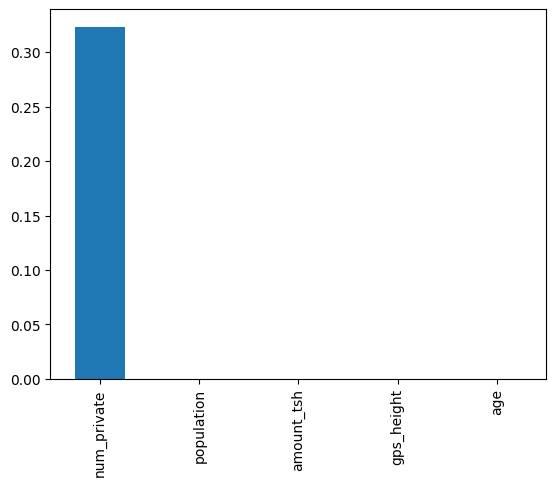

In [16]:
# copy the dataset for ANOVA test
df_int = df.copy(deep=True)

# keep the numerical columns and the target label
int_var = [col for col in df.columns if df[col].dtypes in ['int64', 'float64']] + ['status_group']
df_int = df_int[int_var]

# get the input and output variables
X = df_int.drop('status_group', axis=1)
y = df_int['status_group']

# compute the ANOVA F-statistic for each column
select = SelectKBest(f_classif, k=5)
fit = select.fit(X, y)

# compute the p-values for each F-statistic
p_values = {col: np.round(p_value, 4) for col, p_value in zip(X.columns, fit.pvalues_)}

p_values = pd.Series(p_values.values(),index = p_values.keys())
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

In [17]:
# columns with high p-values from ANOVA test
anova_drop = ['num_private']
df = df.drop(anova_drop, axis=1)

### Testing Categorical Features With Chi-Square Test

In [18]:
# copy the dataframe for chi square tests
df_chi = df.copy(deep=True)

# keep the categorical variables in the data frame
cat_var = [col for col in df_chi.columns if df[col].dtypes == 'object']
df_chi = df_chi[cat_var]

# encode the categorical variables
label_encoder = LabelEncoder()
for col in df_chi.columns:
    df_chi[col] = label_encoder.fit_transform(df_chi[col])

# get input and output variables
X = df_chi.drop('status_group',axis=1)
y = df_chi['status_group']

# perform chi-square tests
chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)


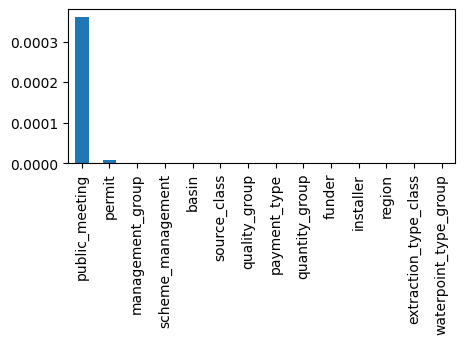

In [19]:
plt.figure(figsize=(5,2))
p_values.plot.bar()
plt.show()


### Baseline Models

In [20]:
X = df.drop('status_group', axis=1)
y = df['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [21]:
X_train.isnull().sum()

amount_tsh                  0
funder                   2548
gps_height                  0
installer                2555
basin                       0
region                      0
population                  0
public_meeting           2297
scheme_management        2733
permit                   2151
extraction_type_class       0
management_group            0
payment_type                0
quality_group               0
quantity_group              0
source_class                0
waterpoint_type_group       0
age                         0
dtype: int64

In [22]:
# encode the target label
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [23]:
# train a dummy classifier
dummy_clf = DummyClassifier(strategy="uniform", random_state=42)
dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)

In [24]:
# Define the column transformer
cat_var = [ind for ind, col in enumerate(X_train.columns) if X_train[col].dtypes=='object']
num_var = [ind for ind, col in enumerate(X_train.columns) if X_train[col].dtypes in ['int64', 'float64']]

# Define column transformer for one-hot encoding categorical features
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define preprocessing pipeline
preprocessing_pipeline = ColumnTransformer([
    ('cat_transformer', categorical_transformer, cat_var)
  # replace missing categorical values with mode and one-hot encode
], remainder='passthrough')

# Define final pipeline with preprocessing and logistic regression model
pipeline_log = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('logistic_regression', LogisticRegression())
])

pipeline_log.fit(X_train, y_train)
y_pred_log = pipeline_log.predict(X_test)

In [25]:
f2_score_dummy = fbeta_score(y_test, y_pred_dummy, average='micro', beta=2)
f2_score_log = fbeta_score(y_test, y_pred_log, average='micro', beta=2)

print(f'F2 score of dummy classifier: {f2_score_dummy}')
print(f'F2 score of logistic regression classifier: {f2_score_log}')

F2 score of dummy classifier: 0.32895622895622895
F2 score of logistic regression classifier: 0.6836139169472503


### CatBoost Model

In [26]:
# create a f2 score metric for hyperparameter tuning
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='weighted')
f2_scorer = make_scorer(f2_score)

In [58]:

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'depth': trial.suggest_int('depth', 4, 10)
    }

    cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    cat_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Get list of columns with missing values
    cols_with_missing = df.columns[df.isna().any()].tolist()


    # set up the wrapper with the SimpleImputer
    imputer = SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                        variables = cols_with_missing)

    scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                    variables=num_cols)


    pipeline_cbc = Pipeline(steps=[('impute', imputer),
                            ('scaler', scaler),
                            ('rare_label', RareLabelEncoder(replace_with='Other', n_categories=10, variables=cat_cols)),
                            ('catboost', CatBoostClassifier(**params, verbose=False, cat_features=cat_indices, early_stopping_rounds=50))
                                ])
    
    # Define cross-validation method
    sfk = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    y_train_df = pd.Series(y_train)

     # Train and evaluate model using f1_score
    f2_scores = []
    for train_idx, test_idx in sfk.split(X_train, y_train_df):
        X_train_split, X_test_split = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_split, y_test_split = y_train_df.iloc[train_idx], y_train_df.iloc[test_idx]

        pipeline_cbc.fit(X_train_split, y_train_split)
        y_pred = pipeline_cbc.predict(X_test_split)

        f2_scores.append(fbeta_score(y_test_split, y_pred, beta=2, average='micro'))

    return np.mean(f2_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-05-05 22:28:10,292] A new study created in memory with name: no-name-1e287b86-82f2-4225-b9cf-dfd2d52c30f4
[W 2023-05-05 22:28:13,598] Trial 0 failed with parameters: {'learning_rate': 0.05260786231994007, 'iterations': 600, 'depth': 5} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\aashi\Desktop\Personal Projects\Data Science\Identifying-Faulty-Water-Pumps-With-Machine-Learning\venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\aashi\AppData\Local\Temp\ipykernel_12452\2660636368.py", line 40, in objective
    pipeline_cbc.fit(X_train_split, y_train_split)
  File "c:\Users\aashi\Desktop\Personal Projects\Data Science\Identifying-Faulty-Water-Pumps-With-Machine-Learning\venv\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\aashi\Desktop\Personal Projects\Data Sci

KeyboardInterrupt: 

In [34]:
best_params = study.best_params
# perform one hot encoding on the categorical features

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
cat_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get list of columns with missing values
cols_with_missing = df.columns[df.isna().any()].tolist()

# sspecify columns for imputer
imputer = SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                    variables = cols_with_missing)

# specify columns for standard scaler
scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                variables=num_cols)

# create pipeline
pipeline_cbc = Pipeline(steps=[('impute', imputer),
                            ('scaler', scaler),
                            ('rare_label', RareLabelEncoder(replace_with='Unknown', n_categories=10, variables=cat_cols)),
                            ('catboost', CatBoostClassifier(**best_params, verbose=False, cat_features=cat_indices, early_stopping_rounds=50))
                                ])

# fit pipeline
pipeline_cbc.fit(X_train, y_train)

#generate predictions
y_pred_cbc= pipeline_cbc.predict(X_test)

In [35]:
f2_score_cbc = fbeta_score(y_pred_cbc, y_test, beta=2, average='micro')

In [50]:
X_train[cat_cols].dtypes
X_test.head()

,amount_tsh,funder,gps_height,installer,basin,region,population,public_meeting,scheme_management,permit,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_class,waterpoint_type_group,age
19321,-0.097143,Unhcr,-0.965856,TWESA,Lake Tanganyika,Kigoma,-0.389357,True,VWC,False,handpump,user-group,unknown,unknown,enough,groundwater,hand pump,-45.021473
9219,-0.097143,Lga,-0.967818,LGA,Ruvuma / Southern Coast,Mtwara,-0.390057,True,VWC,True,gravity,user-group,never pay,good,enough,groundwater,communal standpipe,-45.047494
32072,-0.097143,Tasaf,-0.967824,District Water Department,Ruvuma / Southern Coast,Lindi,-0.389030,True,VWC,False,other,user-group,never pay,milky,seasonal,groundwater,other,-45.096285
21900,-0.097143,Dwe,-0.968620,DWE,Lake Tanganyika,Tabora,-0.390431,True,VWC,True,handpump,user-group,never pay,good,enough,groundwater,hand pump,-45.402036
55124,-0.097038,Government Of Tanzania,-0.965833,DWE,Lake Tanganyika,Kigoma,-0.388329,True,Water authority,True,gravity,user-group,annually,good,enough,surface,communal standpipe,-45.083274


### LGBM

In [72]:

def objective(trial):

    global X_train, X_test, y_train, y_test

    def f2_score(y_true, y_pred):
        return fbeta_score(y_true, y_pred, beta=2, average='weighted')
    f2_scorer = make_scorer(f2_score)


    # Define the hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        "lambda_l2": trial.suggest_int("lambda_l1", 0, 100, step=5)
    }

    num_cols = [col for i, col in enumerate(X_train.columns) if X_train[col].dtypes in ['float64', 'int64']]
    cat_cols = [col for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
    cat_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
    cols_with_missing = df.columns[df.isna().any()].tolist()


    X_cat = X_train.copy(deep=True)
    X_test_cat = X_test.copy(deep=True)

    for col in cat_cols:
        X_cat[col] = X_cat[col].astype('category')
        X_test_cat[col] = X_test_cat[col].astype('category')

    y_train_df = pd.Series(y_train)

    # set up the wrapper with the SimpleImputer
    imputer = SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                        variables = cols_with_missing)
    # specify columns for standard scaler
    scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                    variables=num_cols)


    skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
    f2_scores = []

    lgb_model = lgb.LGBMClassifier(**params, 
                            metric='multi_logloss',
                            categorical_feature=cat_indices)

    for idx, (train_idx, test_idx) in enumerate(skf.split(X_cat, y_train_df)):
        X_train_split, X_test_split = X_cat.iloc[train_idx], X_cat.iloc[test_idx]
        y_train_split, y_test_split = y_train_df.iloc[train_idx], y_train_df.iloc[test_idx]
        
        pipeline = Pipeline(steps=[('scaler', scaler),
                                   ('lgb_model', lgb_model)])
        #model = lgb.LGBMClassifier(**params, categorical_feature=cat_indices)
        pipeline.fit(X_train_split, 
                     y_train_split, 
                     lgb_model__early_stopping_rounds=50,
                     lgb_model__eval_set=[(X_test_split, y_test_split)], 
                     lgb_model__verbose=False)
        
        y_pred = pipeline.predict(X_test_split)
        f2_score_lgbm = fbeta_score(y_test_split, y_pred, beta=2, average='micro')
        f2_scores.append(f2_score_lgbm)
        
    return np.mean(f2_scores)
    

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective, n_trials=500)

[I 2023-05-06 12:21:36,570] A new study created in memory with name: no-name-e04db201-7db8-4444-8dc0-b38fe3351114


[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


[I 2023-05-06 12:21:40,757] Trial 0 finished with value: 0.7654882154882156 and parameters: {'learning_rate': 0.05632725923643052, 'num_leaves': 122, 'max_depth': 7, 'lambda_l1': 30}. Best is trial 0 with value: 0.7654882154882156.


[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65


[I 2023-05-06 12:21:43,220] Trial 1 finished with value: 0.7486050986050987 and parameters: {'learning_rate': 0.029421015808496508, 'num_leaves': 134, 'max_depth': 5, 'lambda_l1': 65}. Best is trial 0 with value: 0.7654882154882156.


[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2023-05-06 12:21:48,718] Trial 2 finished with value: 0.7594035594035594 and parameters: {'learning_rate': 0.019622263092825522, 'num_leaves': 242, 'max_depth': 10, 'lambda_l1': 25}. Best is trial 0 with value: 0.7654882154882156.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:21:50,933] Trial 3 finished with value: 0.7605339105339106 and parameters: {'learning_rate': 0.08476950224786736, 'num_leaves': 16, 'max_depth': 5, 'lambda_l1': 5}. Best is trial 0 with value: 0.7654882154882156.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:21:55,816] Trial 4 finished with value: 0.7769119769119769 and parameters: {'learning_rate': 0.082668707889296, 'num_leaves': 96, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 4 with value: 0.7769119769119769.


[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2023-05-06 12:22:01,723] Trial 5 finished with value: 0.7645743145743146 and parameters: {'learning_rate': 0.03431514684190735, 'num_leaves': 120, 'max_depth': 9, 'lambda_l1': 25}. Best is trial 4 with value: 0.7769119769119769.


[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


[I 2023-05-06 12:22:05,919] Trial 6 finished with value: 0.7487734487734489 and parameters: {'learning_rate': 0.0415133173618344, 'num_leaves': 250, 'max_depth': 4, 'lambda_l1': 70}. Best is trial 4 with value: 0.7769119769119769.


[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85


[I 2023-05-06 12:22:12,307] Trial 7 finished with value: 0.7616402116402116 and parameters: {'learning_rate': 0.04124367847986723, 'num_leaves': 198, 'max_depth': 8, 'lambda_l1': 85}. Best is trial 4 with value: 0.7769119769119769.


[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


[I 2023-05-06 12:22:16,675] Trial 8 finished with value: 0.7371091871091872 and parameters: {'learning_rate': 0.00988629768418654, 'num_leaves': 95, 'max_depth': 8, 'lambda_l1': 100}. Best is trial 4 with value: 0.7769119769119769.


[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


[I 2023-05-06 12:22:18,772] Trial 9 finished with value: 0.7567580567580566 and parameters: {'learning_rate': 0.0846246331667987, 'num_leaves': 9, 'max_depth': 6, 'lambda_l1': 100}. Best is trial 4 with value: 0.7769119769119769.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:22:24,110] Trial 10 finished with value: 0.7716209716209717 and parameters: {'learning_rate': 0.07088476612234665, 'num_leaves': 50, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 4 with value: 0.7769119769119769.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:22:28,590] Trial 11 finished with value: 0.7746512746512746 and parameters: {'learning_rate': 0.06785774147404963, 'num_leaves': 67, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 4 with value: 0.7769119769119769.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:22:33,507] Trial 12 finished with value: 0.7763107263107263 and parameters: {'learning_rate': 0.09245689183999672, 'num_leaves': 77, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 4 with value: 0.7769119769119769.


[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


[I 2023-05-06 12:22:39,904] Trial 13 finished with value: 0.7771043771043771 and parameters: {'learning_rate': 0.09847016162908104, 'num_leaves': 166, 'max_depth': 11, 'lambda_l1': 40}. Best is trial 13 with value: 0.7771043771043771.


[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45


[I 2023-05-06 12:22:47,292] Trial 14 finished with value: 0.7765271765271765 and parameters: {'learning_rate': 0.09893076348986579, 'num_leaves': 170, 'max_depth': 10, 'lambda_l1': 45}. Best is trial 13 with value: 0.7771043771043771.


[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


[I 2023-05-06 12:22:58,193] Trial 15 finished with value: 0.7762385762385762 and parameters: {'learning_rate': 0.0980869785945412, 'num_leaves': 159, 'max_depth': 11, 'lambda_l1': 40}. Best is trial 13 with value: 0.7771043771043771.


[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


[I 2023-05-06 12:23:07,552] Trial 16 finished with value: 0.7737854737854738 and parameters: {'learning_rate': 0.07453135869057513, 'num_leaves': 204, 'max_depth': 10, 'lambda_l1': 60}. Best is trial 13 with value: 0.7771043771043771.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:23:15,010] Trial 17 finished with value: 0.7757575757575758 and parameters: {'learning_rate': 0.0579856222510388, 'num_leaves': 154, 'max_depth': 11, 'lambda_l1': 15}. Best is trial 13 with value: 0.7771043771043771.


[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


[I 2023-05-06 12:23:23,071] Trial 18 finished with value: 0.7756613756613757 and parameters: {'learning_rate': 0.08470034517009163, 'num_leaves': 198, 'max_depth': 11, 'lambda_l1': 55}. Best is trial 13 with value: 0.7771043771043771.


[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


[I 2023-05-06 12:23:30,022] Trial 19 finished with value: 0.7725589225589227 and parameters: {'learning_rate': 0.0992800329224423, 'num_leaves': 100, 'max_depth': 9, 'lambda_l1': 35}. Best is trial 13 with value: 0.7771043771043771.


[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


[I 2023-05-06 12:23:35,312] Trial 20 finished with value: 0.771933621933622 and parameters: {'learning_rate': 0.07887364382906849, 'num_leaves': 49, 'max_depth': 12, 'lambda_l1': 75}. Best is trial 13 with value: 0.7771043771043771.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:23:43,700] Trial 21 finished with value: 0.7775372775372774 and parameters: {'learning_rate': 0.09240906363106512, 'num_leaves': 167, 'max_depth': 10, 'lambda_l1': 15}. Best is trial 21 with value: 0.7775372775372774.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:23:51,211] Trial 22 finished with value: 0.7790283790283791 and parameters: {'learning_rate': 0.0898835979853016, 'num_leaves': 182, 'max_depth': 11, 'lambda_l1': 15}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:23:57,109] Trial 23 finished with value: 0.7742424242424243 and parameters: {'learning_rate': 0.09118946504593543, 'num_leaves': 181, 'max_depth': 9, 'lambda_l1': 15}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 12:24:05,144] Trial 24 finished with value: 0.7779220779220779 and parameters: {'learning_rate': 0.09017192671560831, 'num_leaves': 224, 'max_depth': 10, 'lambda_l1': 20}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:24:12,514] Trial 25 finished with value: 0.7746753246753247 and parameters: {'learning_rate': 0.06768126784224768, 'num_leaves': 227, 'max_depth': 10, 'lambda_l1': 15}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2023-05-06 12:24:18,289] Trial 26 finished with value: 0.775108225108225 and parameters: {'learning_rate': 0.09060332607946396, 'num_leaves': 236, 'max_depth': 9, 'lambda_l1': 25}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 12:24:22,615] Trial 27 finished with value: 0.7695045695045696 and parameters: {'learning_rate': 0.07495378942108054, 'num_leaves': 219, 'max_depth': 7, 'lambda_l1': 20}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:24:27,638] Trial 28 finished with value: 0.7695286195286194 and parameters: {'learning_rate': 0.06164539537344028, 'num_leaves': 144, 'max_depth': 8, 'lambda_l1': 10}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


[I 2023-05-06 12:24:33,915] Trial 29 finished with value: 0.775012025012025 and parameters: {'learning_rate': 0.07929547254668137, 'num_leaves': 183, 'max_depth': 10, 'lambda_l1': 30}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50


[I 2023-05-06 12:24:42,111] Trial 30 finished with value: 0.7750841750841752 and parameters: {'learning_rate': 0.091379917432047, 'num_leaves': 214, 'max_depth': 11, 'lambda_l1': 50}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


[I 2023-05-06 12:24:50,627] Trial 31 finished with value: 0.7767917267917267 and parameters: {'learning_rate': 0.09987501149375008, 'num_leaves': 174, 'max_depth': 11, 'lambda_l1': 35}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


[I 2023-05-06 12:24:57,973] Trial 32 finished with value: 0.7778980278980279 and parameters: {'learning_rate': 0.08939400591837637, 'num_leaves': 124, 'max_depth': 11, 'lambda_l1': 35}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 12:25:04,472] Trial 33 finished with value: 0.7755411255411255 and parameters: {'learning_rate': 0.08881431095393058, 'num_leaves': 121, 'max_depth': 10, 'lambda_l1': 20}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2023-05-06 12:25:10,801] Trial 34 finished with value: 0.7754208754208755 and parameters: {'learning_rate': 0.0790231674876525, 'num_leaves': 136, 'max_depth': 10, 'lambda_l1': 25}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:25:17,678] Trial 35 finished with value: 0.7767917267917269 and parameters: {'learning_rate': 0.08705188202351449, 'num_leaves': 188, 'max_depth': 11, 'lambda_l1': 10}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


[I 2023-05-06 12:25:23,259] Trial 36 finished with value: 0.772991822991823 and parameters: {'learning_rate': 0.09481396120618928, 'num_leaves': 148, 'max_depth': 9, 'lambda_l1': 30}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 12:25:29,206] Trial 37 finished with value: 0.7739297739297739 and parameters: {'learning_rate': 0.08309490356715785, 'num_leaves': 108, 'max_depth': 10, 'lambda_l1': 20}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:25:33,277] Trial 38 finished with value: 0.7708032708032708 and parameters: {'learning_rate': 0.09312755446333368, 'num_leaves': 129, 'max_depth': 7, 'lambda_l1': 5}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


[I 2023-05-06 12:25:38,854] Trial 39 finished with value: 0.7691678691678693 and parameters: {'learning_rate': 0.05185037951629879, 'num_leaves': 206, 'max_depth': 9, 'lambda_l1': 35}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:25:43,982] Trial 40 finished with value: 0.772029822029822 and parameters: {'learning_rate': 0.08461980320304122, 'num_leaves': 256, 'max_depth': 8, 'lambda_l1': 5}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45


[I 2023-05-06 12:25:53,055] Trial 41 finished with value: 0.7776334776334776 and parameters: {'learning_rate': 0.09431476233147863, 'num_leaves': 164, 'max_depth': 11, 'lambda_l1': 45}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45


[I 2023-05-06 12:25:59,776] Trial 42 finished with value: 0.7771524771524772 and parameters: {'learning_rate': 0.09450839104745318, 'num_leaves': 141, 'max_depth': 11, 'lambda_l1': 45}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2023-05-06 12:26:07,863] Trial 43 finished with value: 0.777032227032227 and parameters: {'learning_rate': 0.08542374137353496, 'num_leaves': 162, 'max_depth': 12, 'lambda_l1': 25}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50


[I 2023-05-06 12:26:10,017] Trial 44 finished with value: 0.7585618085618085 and parameters: {'learning_rate': 0.0882192602750213, 'num_leaves': 188, 'max_depth': 4, 'lambda_l1': 50}. Best is trial 22 with value: 0.7790283790283791.


[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


[I 2023-05-06 12:26:17,653] Trial 45 finished with value: 0.7800144300144299 and parameters: {'learning_rate': 0.09520189484774694, 'num_leaves': 242, 'max_depth': 12, 'lambda_l1': 30}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


[I 2023-05-06 12:26:25,219] Trial 46 finished with value: 0.7773929773929774 and parameters: {'learning_rate': 0.0812971423697859, 'num_leaves': 238, 'max_depth': 12, 'lambda_l1': 30}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


[I 2023-05-06 12:26:32,006] Trial 47 finished with value: 0.7781385281385282 and parameters: {'learning_rate': 0.09540132056186239, 'num_leaves': 228, 'max_depth': 12, 'lambda_l1': 40}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


[I 2023-05-06 12:26:40,203] Trial 48 finished with value: 0.7776094276094278 and parameters: {'learning_rate': 0.08892167565133403, 'num_leaves': 245, 'max_depth': 12, 'lambda_l1': 40}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


[I 2023-05-06 12:26:47,979] Trial 49 finished with value: 0.777080327080327 and parameters: {'learning_rate': 0.09629045173251526, 'num_leaves': 227, 'max_depth': 12, 'lambda_l1': 35}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2023-05-06 12:26:54,845] Trial 50 finished with value: 0.7782106782106782 and parameters: {'learning_rate': 0.07406272775242094, 'num_leaves': 228, 'max_depth': 12, 'lambda_l1': 25}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2023-05-06 12:27:01,553] Trial 51 finished with value: 0.7788840788840788 and parameters: {'learning_rate': 0.08737510494216687, 'num_leaves': 228, 'max_depth': 12, 'lambda_l1': 25}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2023-05-06 12:27:09,172] Trial 52 finished with value: 0.7800144300144299 and parameters: {'learning_rate': 0.08158492864079336, 'num_leaves': 228, 'max_depth': 12, 'lambda_l1': 25}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2023-05-06 12:27:18,606] Trial 53 finished with value: 0.7799422799422798 and parameters: {'learning_rate': 0.08235111283941042, 'num_leaves': 234, 'max_depth': 12, 'lambda_l1': 25}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2023-05-06 12:27:27,225] Trial 54 finished with value: 0.777032227032227 and parameters: {'learning_rate': 0.07610946340693454, 'num_leaves': 249, 'max_depth': 12, 'lambda_l1': 25}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:27:35,337] Trial 55 finished with value: 0.7786676286676287 and parameters: {'learning_rate': 0.08099122772981321, 'num_leaves': 211, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:27:43,281] Trial 56 finished with value: 0.7779942279942279 and parameters: {'learning_rate': 0.08287733091782995, 'num_leaves': 210, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 45 with value: 0.7800144300144299.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:27:50,755] Trial 57 finished with value: 0.781048581048581 and parameters: {'learning_rate': 0.08091456519650375, 'num_leaves': 197, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:27:53,929] Trial 58 finished with value: 0.7654641654641655 and parameters: {'learning_rate': 0.0697994136525717, 'num_leaves': 198, 'max_depth': 6, 'lambda_l1': 0}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:28:02,049] Trial 59 finished with value: 0.7784752284752287 and parameters: {'learning_rate': 0.0862254303421547, 'num_leaves': 237, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:28:09,946] Trial 60 finished with value: 0.7783309283309284 and parameters: {'learning_rate': 0.07736490929061013, 'num_leaves': 217, 'max_depth': 11, 'lambda_l1': 15}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:28:18,652] Trial 61 finished with value: 0.7805916305916306 and parameters: {'learning_rate': 0.08120690478353187, 'num_leaves': 256, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:28:26,123] Trial 62 finished with value: 0.7789321789321789 and parameters: {'learning_rate': 0.08228977283877356, 'num_leaves': 256, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:28:33,417] Trial 63 finished with value: 0.7799422799422798 and parameters: {'learning_rate': 0.08123663254978947, 'num_leaves': 254, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:28:40,786] Trial 64 finished with value: 0.7778499278499278 and parameters: {'learning_rate': 0.07227315445046802, 'num_leaves': 243, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:28:47,096] Trial 65 finished with value: 0.7799663299663301 and parameters: {'learning_rate': 0.07813936410276945, 'num_leaves': 248, 'max_depth': 11, 'lambda_l1': 15}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95


[I 2023-05-06 12:28:53,653] Trial 66 finished with value: 0.7745310245310245 and parameters: {'learning_rate': 0.07813278955928193, 'num_leaves': 247, 'max_depth': 12, 'lambda_l1': 95}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:28:59,993] Trial 67 finished with value: 0.7766474266474267 and parameters: {'learning_rate': 0.06526642382326216, 'num_leaves': 236, 'max_depth': 11, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 12:29:07,159] Trial 68 finished with value: 0.7792929292929293 and parameters: {'learning_rate': 0.07387161342456579, 'num_leaves': 256, 'max_depth': 12, 'lambda_l1': 20}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:29:14,487] Trial 69 finished with value: 0.7807599807599809 and parameters: {'learning_rate': 0.07195035374967321, 'num_leaves': 220, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:29:21,895] Trial 70 finished with value: 0.7792688792688792 and parameters: {'learning_rate': 0.07685861573577965, 'num_leaves': 221, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:29:29,186] Trial 71 finished with value: 0.7789321789321789 and parameters: {'learning_rate': 0.07280706306297546, 'num_leaves': 240, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:29:36,147] Trial 72 finished with value: 0.7795815295815295 and parameters: {'learning_rate': 0.08024940765974592, 'num_leaves': 235, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:29:43,281] Trial 73 finished with value: 0.7773689273689274 and parameters: {'learning_rate': 0.07073470429740301, 'num_leaves': 251, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 12:29:50,040] Trial 74 finished with value: 0.7769119769119769 and parameters: {'learning_rate': 0.08387912181974068, 'num_leaves': 200, 'max_depth': 12, 'lambda_l1': 20}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:29:56,771] Trial 75 finished with value: 0.7810004810004809 and parameters: {'learning_rate': 0.0765946630937341, 'num_leaves': 246, 'max_depth': 11, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:30:03,865] Trial 76 finished with value: 0.7792929292929293 and parameters: {'learning_rate': 0.07834215544416993, 'num_leaves': 232, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


[I 2023-05-06 12:30:10,267] Trial 77 finished with value: 0.7749879749879751 and parameters: {'learning_rate': 0.0752928267152119, 'num_leaves': 244, 'max_depth': 11, 'lambda_l1': 70}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:30:16,495] Trial 78 finished with value: 0.7778980278980279 and parameters: {'learning_rate': 0.06506611381914286, 'num_leaves': 219, 'max_depth': 11, 'lambda_l1': 15}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


[I 2023-05-06 12:30:23,277] Trial 79 finished with value: 0.7785714285714286 and parameters: {'learning_rate': 0.08470254970847647, 'num_leaves': 208, 'max_depth': 11, 'lambda_l1': 30}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:30:30,793] Trial 80 finished with value: 0.7807359307359308 and parameters: {'learning_rate': 0.07104074049971194, 'num_leaves': 246, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:30:33,238] Trial 81 finished with value: 0.7618326118326119 and parameters: {'learning_rate': 0.07623568009422299, 'num_leaves': 244, 'max_depth': 5, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:30:41,230] Trial 82 finished with value: 0.7785714285714286 and parameters: {'learning_rate': 0.06998846760924463, 'num_leaves': 233, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:30:44,527] Trial 83 finished with value: 0.7675565175565175 and parameters: {'learning_rate': 0.08024400373628005, 'num_leaves': 31, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:30:51,811] Trial 84 finished with value: 0.7785473785473785 and parameters: {'learning_rate': 0.07259454576982334, 'num_leaves': 223, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 12:30:58,289] Trial 85 finished with value: 0.7779220779220779 and parameters: {'learning_rate': 0.08664460643203517, 'num_leaves': 248, 'max_depth': 11, 'lambda_l1': 20}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:31:05,664] Trial 86 finished with value: 0.7793650793650794 and parameters: {'learning_rate': 0.09234990391305033, 'num_leaves': 217, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:31:12,410] Trial 87 finished with value: 0.7791245791245792 and parameters: {'learning_rate': 0.08306677307073675, 'num_leaves': 192, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 12:31:19,222] Trial 88 finished with value: 0.7784511784511784 and parameters: {'learning_rate': 0.07861862580105183, 'num_leaves': 239, 'max_depth': 11, 'lambda_l1': 20}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:31:26,166] Trial 89 finished with value: 0.7786195286195285 and parameters: {'learning_rate': 0.06828976755363907, 'num_leaves': 232, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:31:32,298] Trial 90 finished with value: 0.775012025012025 and parameters: {'learning_rate': 0.07607182364021806, 'num_leaves': 250, 'max_depth': 10, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:31:39,862] Trial 91 finished with value: 0.778018278018278 and parameters: {'learning_rate': 0.0810561410257111, 'num_leaves': 253, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:31:46,673] Trial 92 finished with value: 0.7803751803751804 and parameters: {'learning_rate': 0.0900394065715406, 'num_leaves': 241, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:31:53,802] Trial 93 finished with value: 0.7763107263107264 and parameters: {'learning_rate': 0.09067459631156008, 'num_leaves': 242, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:32:00,493] Trial 94 finished with value: 0.7773208273208273 and parameters: {'learning_rate': 0.08625778955548143, 'num_leaves': 225, 'max_depth': 11, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


[I 2023-05-06 12:32:08,140] Trial 95 finished with value: 0.7772727272727272 and parameters: {'learning_rate': 0.09772727964352138, 'num_leaves': 229, 'max_depth': 12, 'lambda_l1': 30}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:32:15,949] Trial 96 finished with value: 0.7809042809042809 and parameters: {'learning_rate': 0.08763477698449573, 'num_leaves': 241, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:32:22,284] Trial 97 finished with value: 0.7777056277056277 and parameters: {'learning_rate': 0.08918838090597829, 'num_leaves': 79, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:32:29,809] Trial 98 finished with value: 0.7795815295815296 and parameters: {'learning_rate': 0.09302787790455865, 'num_leaves': 247, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:32:32,869] Trial 99 finished with value: 0.7656806156806156 and parameters: {'learning_rate': 0.08487831319559112, 'num_leaves': 240, 'max_depth': 6, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:32:40,152] Trial 100 finished with value: 0.7803992303992304 and parameters: {'learning_rate': 0.09016317741305224, 'num_leaves': 214, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:32:47,338] Trial 101 finished with value: 0.7794612794612794 and parameters: {'learning_rate': 0.08867012733332118, 'num_leaves': 213, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:32:53,683] Trial 102 finished with value: 0.7785954785954785 and parameters: {'learning_rate': 0.09638575811260591, 'num_leaves': 202, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:33:00,471] Trial 103 finished with value: 0.7784752284752287 and parameters: {'learning_rate': 0.09089135007550504, 'num_leaves': 223, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


[I 2023-05-06 12:33:07,423] Trial 104 finished with value: 0.7783068783068784 and parameters: {'learning_rate': 0.08634766845216581, 'num_leaves': 250, 'max_depth': 12, 'lambda_l1': 60}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:33:13,422] Trial 105 finished with value: 0.778980278980279 and parameters: {'learning_rate': 0.093368522205553, 'num_leaves': 216, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:33:20,579] Trial 106 finished with value: 0.781024531024531 and parameters: {'learning_rate': 0.083633327943205, 'num_leaves': 232, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:33:27,528] Trial 107 finished with value: 0.7804232804232804 and parameters: {'learning_rate': 0.08787352476576593, 'num_leaves': 194, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:33:33,972] Trial 108 finished with value: 0.780952380952381 and parameters: {'learning_rate': 0.08717866639357626, 'num_leaves': 177, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:33:40,443] Trial 109 finished with value: 0.7780423280423281 and parameters: {'learning_rate': 0.08790731679992242, 'num_leaves': 198, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:33:46,890] Trial 110 finished with value: 0.7785714285714286 and parameters: {'learning_rate': 0.08426140264778086, 'num_leaves': 170, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:33:53,533] Trial 111 finished with value: 0.7809283309283309 and parameters: {'learning_rate': 0.09204170772807023, 'num_leaves': 190, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:34:00,496] Trial 112 finished with value: 0.7795815295815296 and parameters: {'learning_rate': 0.08986819269089166, 'num_leaves': 177, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:34:07,961] Trial 113 finished with value: 0.7785233285233285 and parameters: {'learning_rate': 0.09197695086375665, 'num_leaves': 192, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:34:14,740] Trial 114 finished with value: 0.7800144300144302 and parameters: {'learning_rate': 0.08768827520156962, 'num_leaves': 184, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:34:22,465] Trial 115 finished with value: 0.7803511303511304 and parameters: {'learning_rate': 0.08543126891046965, 'num_leaves': 193, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 57 with value: 0.781048581048581.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:34:29,583] Trial 116 finished with value: 0.7817700817700818 and parameters: {'learning_rate': 0.07967871020281939, 'num_leaves': 203, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:34:36,561] Trial 117 finished with value: 0.7791245791245792 and parameters: {'learning_rate': 0.08034573670071138, 'num_leaves': 207, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:34:43,058] Trial 118 finished with value: 0.7804473304473305 and parameters: {'learning_rate': 0.08275653912725221, 'num_leaves': 154, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:34:47,728] Trial 119 finished with value: 0.774074074074074 and parameters: {'learning_rate': 0.08270042403399194, 'num_leaves': 188, 'max_depth': 8, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80


[I 2023-05-06 12:34:54,472] Trial 120 finished with value: 0.7746753246753247 and parameters: {'learning_rate': 0.07412834108495266, 'num_leaves': 156, 'max_depth': 12, 'lambda_l1': 80}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:35:01,224] Trial 121 finished with value: 0.7786916786916788 and parameters: {'learning_rate': 0.07854578760049155, 'num_leaves': 176, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:35:08,003] Trial 122 finished with value: 0.7793650793650794 and parameters: {'learning_rate': 0.08341002230518912, 'num_leaves': 195, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:35:15,088] Trial 123 finished with value: 0.7810245310245311 and parameters: {'learning_rate': 0.07694542780115632, 'num_leaves': 206, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:35:21,978] Trial 124 finished with value: 0.7784752284752284 and parameters: {'learning_rate': 0.0761240625744807, 'num_leaves': 204, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:35:28,601] Trial 125 finished with value: 0.7801346801346801 and parameters: {'learning_rate': 0.07164724081059001, 'num_leaves': 152, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:35:34,274] Trial 126 finished with value: 0.7747474747474747 and parameters: {'learning_rate': 0.08054506263155667, 'num_leaves': 181, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:35:41,200] Trial 127 finished with value: 0.7804232804232805 and parameters: {'learning_rate': 0.07733995431191734, 'num_leaves': 187, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:35:48,304] Trial 128 finished with value: 0.7816979316979317 and parameters: {'learning_rate': 0.0751271102975272, 'num_leaves': 186, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:35:54,766] Trial 129 finished with value: 0.7774170274170275 and parameters: {'learning_rate': 0.07522913346134931, 'num_leaves': 172, 'max_depth': 11, 'lambda_l1': 10}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:36:01,702] Trial 130 finished with value: 0.7795815295815296 and parameters: {'learning_rate': 0.07391787680356571, 'num_leaves': 165, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:36:08,345] Trial 131 finished with value: 0.7776575276575276 and parameters: {'learning_rate': 0.07675197646557229, 'num_leaves': 179, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:36:15,448] Trial 132 finished with value: 0.7790283790283791 and parameters: {'learning_rate': 0.07909658978424397, 'num_leaves': 202, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:36:22,533] Trial 133 finished with value: 0.7802549302549302 and parameters: {'learning_rate': 0.07738855765382482, 'num_leaves': 187, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:36:29,281] Trial 134 finished with value: 0.7804713804713804 and parameters: {'learning_rate': 0.07176386585634908, 'num_leaves': 184, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:36:36,073] Trial 135 finished with value: 0.7809764309764309 and parameters: {'learning_rate': 0.07028366487988358, 'num_leaves': 159, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:36:43,084] Trial 136 finished with value: 0.7780663780663781 and parameters: {'learning_rate': 0.07083041837476457, 'num_leaves': 207, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:36:49,236] Trial 137 finished with value: 0.7778739778739778 and parameters: {'learning_rate': 0.06849690598985363, 'num_leaves': 169, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:36:55,798] Trial 138 finished with value: 0.7812409812409813 and parameters: {'learning_rate': 0.07280942942955626, 'num_leaves': 162, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:37:02,187] Trial 139 finished with value: 0.7750360750360751 and parameters: {'learning_rate': 0.07355662528221409, 'num_leaves': 144, 'max_depth': 11, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:37:03,516] Trial 140 finished with value: 0.7386964886964886 and parameters: {'learning_rate': 0.06669297502431973, 'num_leaves': 3, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:37:09,905] Trial 141 finished with value: 0.7766714766714767 and parameters: {'learning_rate': 0.07120871976080435, 'num_leaves': 162, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:37:16,643] Trial 142 finished with value: 0.7781625781625783 and parameters: {'learning_rate': 0.07258343798242894, 'num_leaves': 184, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:37:23,593] Trial 143 finished with value: 0.78003848003848 and parameters: {'learning_rate': 0.06954235717724744, 'num_leaves': 177, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:37:29,879] Trial 144 finished with value: 0.7771765271765272 and parameters: {'learning_rate': 0.07497791057463803, 'num_leaves': 196, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:37:37,005] Trial 145 finished with value: 0.7782587782587781 and parameters: {'learning_rate': 0.06581321294448732, 'num_leaves': 190, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:37:43,476] Trial 146 finished with value: 0.778066378066378 and parameters: {'learning_rate': 0.0643266806967131, 'num_leaves': 199, 'max_depth': 11, 'lambda_l1': 10}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:37:49,059] Trial 147 finished with value: 0.777080327080327 and parameters: {'learning_rate': 0.06976422926070036, 'num_leaves': 137, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:37:55,658] Trial 148 finished with value: 0.7792929292929293 and parameters: {'learning_rate': 0.0801216923753942, 'num_leaves': 173, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:38:02,944] Trial 149 finished with value: 0.7796296296296297 and parameters: {'learning_rate': 0.0678031167941717, 'num_leaves': 211, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:38:09,987] Trial 150 finished with value: 0.77989417989418 and parameters: {'learning_rate': 0.07226697925801154, 'num_leaves': 158, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:38:16,760] Trial 151 finished with value: 0.7816257816257816 and parameters: {'learning_rate': 0.08259306192720879, 'num_leaves': 166, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:38:22,496] Trial 152 finished with value: 0.7796296296296297 and parameters: {'learning_rate': 0.07896951390701112, 'num_leaves': 110, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:38:29,180] Trial 153 finished with value: 0.7798460798460799 and parameters: {'learning_rate': 0.08164089016267445, 'num_leaves': 167, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:38:36,204] Trial 154 finished with value: 0.7805194805194805 and parameters: {'learning_rate': 0.07498864352584153, 'num_leaves': 182, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:38:42,936] Trial 155 finished with value: 0.7786195286195287 and parameters: {'learning_rate': 0.07547225668741972, 'num_leaves': 162, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:38:49,932] Trial 156 finished with value: 0.7805916305916306 and parameters: {'learning_rate': 0.08505711952140191, 'num_leaves': 233, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:38:55,297] Trial 157 finished with value: 0.776960076960077 and parameters: {'learning_rate': 0.08533200217404714, 'num_leaves': 149, 'max_depth': 10, 'lambda_l1': 15}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:39:02,088] Trial 158 finished with value: 0.7774651274651275 and parameters: {'learning_rate': 0.08357322996576388, 'num_leaves': 232, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:39:09,429] Trial 159 finished with value: 0.780952380952381 and parameters: {'learning_rate': 0.08199546168523732, 'num_leaves': 237, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 116 with value: 0.7817700817700818.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:39:17,389] Trial 160 finished with value: 0.7819143819143819 and parameters: {'learning_rate': 0.07987824819950141, 'num_leaves': 238, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:39:24,683] Trial 161 finished with value: 0.7813131313131313 and parameters: {'learning_rate': 0.08148356772752743, 'num_leaves': 238, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:39:29,578] Trial 162 finished with value: 0.775012025012025 and parameters: {'learning_rate': 0.07978287599242748, 'num_leaves': 220, 'max_depth': 9, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:39:36,681] Trial 163 finished with value: 0.7810726310726311 and parameters: {'learning_rate': 0.07793401233793262, 'num_leaves': 238, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:39:43,762] Trial 164 finished with value: 0.7792688792688792 and parameters: {'learning_rate': 0.08206741424959874, 'num_leaves': 236, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:39:50,826] Trial 165 finished with value: 0.7806397306397307 and parameters: {'learning_rate': 0.07806007925092069, 'num_leaves': 226, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:39:58,082] Trial 166 finished with value: 0.7796055796055796 and parameters: {'learning_rate': 0.07680223755911951, 'num_leaves': 239, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:40:04,826] Trial 167 finished with value: 0.7772486772486773 and parameters: {'learning_rate': 0.0798880382173316, 'num_leaves': 228, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:40:11,638] Trial 168 finished with value: 0.7784992784992785 and parameters: {'learning_rate': 0.0833360103333212, 'num_leaves': 244, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:40:19,229] Trial 169 finished with value: 0.7818903318903319 and parameters: {'learning_rate': 0.0874018454366565, 'num_leaves': 222, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:40:21,103] Trial 170 finished with value: 0.7565897065897067 and parameters: {'learning_rate': 0.08687571013658031, 'num_leaves': 237, 'max_depth': 4, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:40:28,367] Trial 171 finished with value: 0.7816257816257816 and parameters: {'learning_rate': 0.08174797240121529, 'num_leaves': 216, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:40:35,580] Trial 172 finished with value: 0.7810966810966811 and parameters: {'learning_rate': 0.08121372109832373, 'num_leaves': 223, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:40:42,463] Trial 173 finished with value: 0.7792929292929293 and parameters: {'learning_rate': 0.0809100939841526, 'num_leaves': 212, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:40:49,399] Trial 174 finished with value: 0.7811447811447811 and parameters: {'learning_rate': 0.08260440779530188, 'num_leaves': 220, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:40:56,350] Trial 175 finished with value: 0.7806397306397307 and parameters: {'learning_rate': 0.08265556913302549, 'num_leaves': 223, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:41:03,788] Trial 176 finished with value: 0.7785473785473785 and parameters: {'learning_rate': 0.07876283425523666, 'num_leaves': 217, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:41:10,933] Trial 177 finished with value: 0.781000481000481 and parameters: {'learning_rate': 0.08547445762293279, 'num_leaves': 224, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


[I 2023-05-06 12:41:17,898] Trial 178 finished with value: 0.774963924963925 and parameters: {'learning_rate': 0.0840450638694854, 'num_leaves': 222, 'max_depth': 12, 'lambda_l1': 90}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:41:25,067] Trial 179 finished with value: 0.7808561808561808 and parameters: {'learning_rate': 0.08593997400600056, 'num_leaves': 205, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:41:31,664] Trial 180 finished with value: 0.7786435786435786 and parameters: {'learning_rate': 0.07956365083600637, 'num_leaves': 215, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:41:39,055] Trial 181 finished with value: 0.7810245310245311 and parameters: {'learning_rate': 0.08169238222233166, 'num_leaves': 226, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:41:46,479] Trial 182 finished with value: 0.7817219817219817 and parameters: {'learning_rate': 0.07774865617329871, 'num_leaves': 232, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:41:53,579] Trial 183 finished with value: 0.7807118807118808 and parameters: {'learning_rate': 0.07684949643956548, 'num_leaves': 229, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:42:00,381] Trial 184 finished with value: 0.7795334295334295 and parameters: {'learning_rate': 0.0780144809392748, 'num_leaves': 225, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:42:07,677] Trial 185 finished with value: 0.7799663299663301 and parameters: {'learning_rate': 0.08129619902905746, 'num_leaves': 219, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:42:14,605] Trial 186 finished with value: 0.7789321789321789 and parameters: {'learning_rate': 0.08411291092123709, 'num_leaves': 230, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:42:20,721] Trial 187 finished with value: 0.774915824915825 and parameters: {'learning_rate': 0.08086679835242465, 'num_leaves': 210, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:42:27,876] Trial 188 finished with value: 0.778908128908129 and parameters: {'learning_rate': 0.07689464289860166, 'num_leaves': 224, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:42:31,646] Trial 189 finished with value: 0.7705868205868206 and parameters: {'learning_rate': 0.07473686246847826, 'num_leaves': 218, 'max_depth': 7, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:42:39,110] Trial 190 finished with value: 0.781072631072631 and parameters: {'learning_rate': 0.07901319202318004, 'num_leaves': 232, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:42:46,685] Trial 191 finished with value: 0.7811928811928812 and parameters: {'learning_rate': 0.07857584983156903, 'num_leaves': 231, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:42:53,879] Trial 192 finished with value: 0.7798701298701297 and parameters: {'learning_rate': 0.07948812865354395, 'num_leaves': 233, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:43:00,984] Trial 193 finished with value: 0.7805675805675806 and parameters: {'learning_rate': 0.08250256307385713, 'num_leaves': 229, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:43:07,786] Trial 194 finished with value: 0.7796055796055796 and parameters: {'learning_rate': 0.07792941422151453, 'num_leaves': 234, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:43:14,791] Trial 195 finished with value: 0.7802549302549302 and parameters: {'learning_rate': 0.08466141336668026, 'num_leaves': 223, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:43:22,135] Trial 196 finished with value: 0.7813371813371814 and parameters: {'learning_rate': 0.08088161716813402, 'num_leaves': 213, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


[I 2023-05-06 12:43:28,840] Trial 197 finished with value: 0.7768879268879268 and parameters: {'learning_rate': 0.08158966911592344, 'num_leaves': 213, 'max_depth': 12, 'lambda_l1': 55}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:43:36,926] Trial 198 finished with value: 0.7801587301587302 and parameters: {'learning_rate': 0.07960930085036182, 'num_leaves': 208, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:43:43,970] Trial 199 finished with value: 0.781048581048581 and parameters: {'learning_rate': 0.0832118264414465, 'num_leaves': 220, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:43:50,806] Trial 200 finished with value: 0.779148629148629 and parameters: {'learning_rate': 0.08366510374765747, 'num_leaves': 216, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:43:57,979] Trial 201 finished with value: 0.7784511784511784 and parameters: {'learning_rate': 0.08126397083308459, 'num_leaves': 202, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:44:06,872] Trial 202 finished with value: 0.7804713804713805 and parameters: {'learning_rate': 0.05638789391261474, 'num_leaves': 222, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:44:13,846] Trial 203 finished with value: 0.7806637806637807 and parameters: {'learning_rate': 0.08574193589853907, 'num_leaves': 229, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:44:21,037] Trial 204 finished with value: 0.7798460798460799 and parameters: {'learning_rate': 0.07907503278746958, 'num_leaves': 210, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:44:27,988] Trial 205 finished with value: 0.7791245791245792 and parameters: {'learning_rate': 0.08288781786567241, 'num_leaves': 219, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:44:35,441] Trial 206 finished with value: 0.7792688792688792 and parameters: {'learning_rate': 0.045575112721462155, 'num_leaves': 227, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:44:42,763] Trial 207 finished with value: 0.7786676286676286 and parameters: {'learning_rate': 0.0776753403146604, 'num_leaves': 232, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:44:49,683] Trial 208 finished with value: 0.7785473785473785 and parameters: {'learning_rate': 0.08077646394555234, 'num_leaves': 214, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:44:56,246] Trial 209 finished with value: 0.7802308802308802 and parameters: {'learning_rate': 0.08575554061186848, 'num_leaves': 206, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:45:03,813] Trial 210 finished with value: 0.7817700817700818 and parameters: {'learning_rate': 0.07610736188015392, 'num_leaves': 239, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:45:12,798] Trial 211 finished with value: 0.7792688792688794 and parameters: {'learning_rate': 0.07543169828813484, 'num_leaves': 240, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:45:20,351] Trial 212 finished with value: 0.7776815776815776 and parameters: {'learning_rate': 0.07903844227112052, 'num_leaves': 236, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:45:27,244] Trial 213 finished with value: 0.7786676286676286 and parameters: {'learning_rate': 0.08242300886225262, 'num_leaves': 224, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:45:34,896] Trial 214 finished with value: 0.7811688311688312 and parameters: {'learning_rate': 0.08424426434363073, 'num_leaves': 234, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:45:42,343] Trial 215 finished with value: 0.7783549783549782 and parameters: {'learning_rate': 0.07426486980456046, 'num_leaves': 242, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:45:50,252] Trial 216 finished with value: 0.779148629148629 and parameters: {'learning_rate': 0.07648251087651875, 'num_leaves': 234, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:45:55,636] Trial 217 finished with value: 0.7771765271765272 and parameters: {'learning_rate': 0.080656143901968, 'num_leaves': 128, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:46:03,010] Trial 218 finished with value: 0.7803270803270803 and parameters: {'learning_rate': 0.07817003008030558, 'num_leaves': 231, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:46:10,666] Trial 219 finished with value: 0.7791245791245792 and parameters: {'learning_rate': 0.08264903157696248, 'num_leaves': 239, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:46:18,322] Trial 220 finished with value: 0.7797739297739298 and parameters: {'learning_rate': 0.06084128622564487, 'num_leaves': 200, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:46:25,724] Trial 221 finished with value: 0.7808561808561808 and parameters: {'learning_rate': 0.08818332357032208, 'num_leaves': 226, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:46:32,949] Trial 222 finished with value: 0.7807118807118808 and parameters: {'learning_rate': 0.08419863294177404, 'num_leaves': 221, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:46:40,161] Trial 223 finished with value: 0.7811688311688312 and parameters: {'learning_rate': 0.08511379768216847, 'num_leaves': 216, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:46:47,266] Trial 224 finished with value: 0.7788600288600289 and parameters: {'learning_rate': 0.08029677297835018, 'num_leaves': 216, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:46:55,126] Trial 225 finished with value: 0.7810004810004809 and parameters: {'learning_rate': 0.08349520061944199, 'num_leaves': 235, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:46:59,427] Trial 226 finished with value: 0.771164021164021 and parameters: {'learning_rate': 0.08683166840731384, 'num_leaves': 210, 'max_depth': 8, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:47:06,786] Trial 227 finished with value: 0.7792448292448292 and parameters: {'learning_rate': 0.08130052070759108, 'num_leaves': 245, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:47:09,273] Trial 228 finished with value: 0.7625541125541125 and parameters: {'learning_rate': 0.07728059717891177, 'num_leaves': 229, 'max_depth': 5, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:47:18,528] Trial 229 finished with value: 0.7766955266955266 and parameters: {'learning_rate': 0.023897866040221052, 'num_leaves': 218, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:47:25,828] Trial 230 finished with value: 0.7811207311207312 and parameters: {'learning_rate': 0.07928759666451198, 'num_leaves': 207, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:47:33,115] Trial 231 finished with value: 0.7798941798941798 and parameters: {'learning_rate': 0.07913256191775989, 'num_leaves': 204, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:47:40,374] Trial 232 finished with value: 0.7803270803270804 and parameters: {'learning_rate': 0.08184165760281352, 'num_leaves': 213, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:47:48,143] Trial 233 finished with value: 0.7817941317941317 and parameters: {'learning_rate': 0.07595662999778825, 'num_leaves': 208, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:47:55,424] Trial 234 finished with value: 0.7793169793169793 and parameters: {'learning_rate': 0.07427397310960149, 'num_leaves': 198, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:48:03,478] Trial 235 finished with value: 0.7804473304473305 and parameters: {'learning_rate': 0.07611794420637395, 'num_leaves': 206, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:48:10,390] Trial 236 finished with value: 0.7793410293410293 and parameters: {'learning_rate': 0.07832661300770329, 'num_leaves': 210, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 160 with value: 0.7819143819143819.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:48:17,821] Trial 237 finished with value: 0.7820346320346321 and parameters: {'learning_rate': 0.07616757811422946, 'num_leaves': 203, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:48:25,093] Trial 238 finished with value: 0.7814333814333815 and parameters: {'learning_rate': 0.07337031543361644, 'num_leaves': 202, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:48:32,421] Trial 239 finished with value: 0.7800144300144302 and parameters: {'learning_rate': 0.0738448418269673, 'num_leaves': 195, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:48:39,571] Trial 240 finished with value: 0.78015873015873 and parameters: {'learning_rate': 0.0736701655927002, 'num_leaves': 202, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:48:47,083] Trial 241 finished with value: 0.780808080808081 and parameters: {'learning_rate': 0.07628826666008556, 'num_leaves': 205, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:48:54,241] Trial 242 finished with value: 0.778908128908129 and parameters: {'learning_rate': 0.07577785145974145, 'num_leaves': 196, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:49:01,572] Trial 243 finished with value: 0.7811928811928812 and parameters: {'learning_rate': 0.07921528102177476, 'num_leaves': 201, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:49:09,192] Trial 244 finished with value: 0.7803030303030303 and parameters: {'learning_rate': 0.07986073783638897, 'num_leaves': 212, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


[I 2023-05-06 12:49:16,199] Trial 245 finished with value: 0.7771524771524772 and parameters: {'learning_rate': 0.07838872486223514, 'num_leaves': 199, 'max_depth': 12, 'lambda_l1': 70}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:49:23,257] Trial 246 finished with value: 0.7790764790764791 and parameters: {'learning_rate': 0.07985509023387184, 'num_leaves': 202, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:49:30,451] Trial 247 finished with value: 0.7794372294372295 and parameters: {'learning_rate': 0.07266211933434388, 'num_leaves': 209, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:49:37,415] Trial 248 finished with value: 0.7791967291967291 and parameters: {'learning_rate': 0.07759919880687095, 'num_leaves': 215, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:49:45,034] Trial 249 finished with value: 0.7808802308802308 and parameters: {'learning_rate': 0.08013680054177777, 'num_leaves': 218, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:49:52,512] Trial 250 finished with value: 0.757960557960558 and parameters: {'learning_rate': 0.009803890072027789, 'num_leaves': 194, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:49:59,424] Trial 251 finished with value: 0.7799663299663299 and parameters: {'learning_rate': 0.07530657803830985, 'num_leaves': 206, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:50:06,051] Trial 252 finished with value: 0.7784992784992785 and parameters: {'learning_rate': 0.08514287454921374, 'num_leaves': 220, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:50:14,424] Trial 253 finished with value: 0.7804954304954306 and parameters: {'learning_rate': 0.08273386947756448, 'num_leaves': 241, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:50:21,554] Trial 254 finished with value: 0.7783790283790285 and parameters: {'learning_rate': 0.07778462623275664, 'num_leaves': 237, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:50:27,831] Trial 255 finished with value: 0.7766474266474267 and parameters: {'learning_rate': 0.08097957682901673, 'num_leaves': 202, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:50:35,464] Trial 256 finished with value: 0.7778980278980279 and parameters: {'learning_rate': 0.04904078346162017, 'num_leaves': 211, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:50:42,851] Trial 257 finished with value: 0.7774651274651275 and parameters: {'learning_rate': 0.03344229959117471, 'num_leaves': 191, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:50:50,789] Trial 258 finished with value: 0.7810726310726311 and parameters: {'learning_rate': 0.07334947010843175, 'num_leaves': 222, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:50:58,568] Trial 259 finished with value: 0.7811928811928812 and parameters: {'learning_rate': 0.07481304174092943, 'num_leaves': 229, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:51:11,790] Trial 260 finished with value: 0.7801587301587302 and parameters: {'learning_rate': 0.07281822494163473, 'num_leaves': 227, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:51:20,528] Trial 261 finished with value: 0.7810004810004809 and parameters: {'learning_rate': 0.07239821943355292, 'num_leaves': 232, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:51:27,853] Trial 262 finished with value: 0.77991822991823 and parameters: {'learning_rate': 0.07478705137826563, 'num_leaves': 224, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 237 with value: 0.7820346320346321.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:51:35,796] Trial 263 finished with value: 0.7821789321789322 and parameters: {'learning_rate': 0.07633962788889542, 'num_leaves': 237, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:51:44,341] Trial 264 finished with value: 0.7808080808080807 and parameters: {'learning_rate': 0.07066646171264185, 'num_leaves': 247, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:51:53,518] Trial 265 finished with value: 0.7448051948051949 and parameters: {'learning_rate': 0.0038689116776668073, 'num_leaves': 237, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:52:01,313] Trial 266 finished with value: 0.7795334295334295 and parameters: {'learning_rate': 0.07374523776122605, 'num_leaves': 241, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:52:08,766] Trial 267 finished with value: 0.7791486291486293 and parameters: {'learning_rate': 0.07477505455180239, 'num_leaves': 216, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:52:16,710] Trial 268 finished with value: 0.7813371813371813 and parameters: {'learning_rate': 0.07618359968699989, 'num_leaves': 230, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:52:24,170] Trial 269 finished with value: 0.7767436267436268 and parameters: {'learning_rate': 0.07642298470511692, 'num_leaves': 234, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:52:31,807] Trial 270 finished with value: 0.7797258297258297 and parameters: {'learning_rate': 0.07584890930175525, 'num_leaves': 229, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:52:40,359] Trial 271 finished with value: 0.7795334295334295 and parameters: {'learning_rate': 0.053561507534944756, 'num_leaves': 243, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:52:44,226] Trial 272 finished with value: 0.7627705627705628 and parameters: {'learning_rate': 0.07719744468183289, 'num_leaves': 237, 'max_depth': 6, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:52:51,741] Trial 273 finished with value: 0.7792929292929293 and parameters: {'learning_rate': 0.06899004456307614, 'num_leaves': 251, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:52:56,595] Trial 274 finished with value: 0.7723424723424723 and parameters: {'learning_rate': 0.07838507326022846, 'num_leaves': 60, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:53:06,232] Trial 275 finished with value: 0.7805435305435305 and parameters: {'learning_rate': 0.07614371592290925, 'num_leaves': 227, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:53:15,792] Trial 276 finished with value: 0.7802068302068302 and parameters: {'learning_rate': 0.07136711966748266, 'num_leaves': 212, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:53:23,418] Trial 277 finished with value: 0.7776334776334776 and parameters: {'learning_rate': 0.08975552819549816, 'num_leaves': 231, 'max_depth': 11, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:53:31,063] Trial 278 finished with value: 0.7812890812890813 and parameters: {'learning_rate': 0.07919068175111116, 'num_leaves': 207, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:53:35,993] Trial 279 finished with value: 0.772053872053872 and parameters: {'learning_rate': 0.09789793652007822, 'num_leaves': 203, 'max_depth': 9, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:53:43,638] Trial 280 finished with value: 0.7805675805675806 and parameters: {'learning_rate': 0.07971884481471053, 'num_leaves': 207, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:53:50,673] Trial 281 finished with value: 0.7781866281866282 and parameters: {'learning_rate': 0.08436691679658581, 'num_leaves': 216, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:53:58,678] Trial 282 finished with value: 0.7794612794612794 and parameters: {'learning_rate': 0.05979911772436227, 'num_leaves': 199, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


[I 2023-05-06 12:54:07,307] Trial 283 finished with value: 0.7760942760942761 and parameters: {'learning_rate': 0.08776324731867365, 'num_leaves': 208, 'max_depth': 12, 'lambda_l1': 75}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:54:14,906] Trial 284 finished with value: 0.7814814814814816 and parameters: {'learning_rate': 0.08187647235195263, 'num_leaves': 219, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:54:22,279] Trial 285 finished with value: 0.7803751803751804 and parameters: {'learning_rate': 0.07931876416158133, 'num_leaves': 213, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:54:28,855] Trial 286 finished with value: 0.7766233766233767 and parameters: {'learning_rate': 0.07520581281039673, 'num_leaves': 219, 'max_depth': 11, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:54:34,712] Trial 287 finished with value: 0.7769360269360269 and parameters: {'learning_rate': 0.08635205236600997, 'num_leaves': 207, 'max_depth': 10, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:54:42,181] Trial 288 finished with value: 0.7821789321789322 and parameters: {'learning_rate': 0.08178453426873351, 'num_leaves': 214, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


[I 2023-05-06 12:54:49,177] Trial 289 finished with value: 0.7771524771524772 and parameters: {'learning_rate': 0.08232870419655906, 'num_leaves': 215, 'max_depth': 12, 'lambda_l1': 40}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:54:56,505] Trial 290 finished with value: 0.779148629148629 and parameters: {'learning_rate': 0.08457949767162658, 'num_leaves': 225, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:55:03,948] Trial 291 finished with value: 0.7762145262145261 and parameters: {'learning_rate': 0.040614693642059885, 'num_leaves': 220, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 12:55:11,312] Trial 292 finished with value: 0.7797017797017798 and parameters: {'learning_rate': 0.08174754861163608, 'num_leaves': 214, 'max_depth': 12, 'lambda_l1': 20}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:55:18,937] Trial 293 finished with value: 0.7806397306397307 and parameters: {'learning_rate': 0.07271760579617449, 'num_leaves': 230, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:55:26,494] Trial 294 finished with value: 0.7772005772005772 and parameters: {'learning_rate': 0.07662624207626044, 'num_leaves': 222, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:55:32,674] Trial 295 finished with value: 0.7788840788840788 and parameters: {'learning_rate': 0.06817530832777244, 'num_leaves': 118, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:55:39,542] Trial 296 finished with value: 0.7791967291967291 and parameters: {'learning_rate': 0.08308702921854373, 'num_leaves': 197, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:55:46,923] Trial 297 finished with value: 0.77991822991823 and parameters: {'learning_rate': 0.0663976205604777, 'num_leaves': 211, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:55:54,463] Trial 298 finished with value: 0.78006253006253 and parameters: {'learning_rate': 0.07807240818128773, 'num_leaves': 235, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:56:00,626] Trial 299 finished with value: 0.7775613275613277 and parameters: {'learning_rate': 0.09998626711405989, 'num_leaves': 147, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45


[I 2023-05-06 12:56:07,995] Trial 300 finished with value: 0.778980278980279 and parameters: {'learning_rate': 0.08929743060402244, 'num_leaves': 218, 'max_depth': 12, 'lambda_l1': 45}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


[I 2023-05-06 12:56:14,534] Trial 301 finished with value: 0.7740981240981242 and parameters: {'learning_rate': 0.08594868230165963, 'num_leaves': 246, 'max_depth': 11, 'lambda_l1': 100}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:56:23,463] Trial 302 finished with value: 0.78006253006253 and parameters: {'learning_rate': 0.08085142626978568, 'num_leaves': 201, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:56:32,847] Trial 303 finished with value: 0.7796777296777296 and parameters: {'learning_rate': 0.07394990189135811, 'num_leaves': 228, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:56:40,516] Trial 304 finished with value: 0.7803030303030303 and parameters: {'learning_rate': 0.09638234867012828, 'num_leaves': 137, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:56:49,568] Trial 305 finished with value: 0.7793891293891294 and parameters: {'learning_rate': 0.05915880258676995, 'num_leaves': 191, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:56:58,757] Trial 306 finished with value: 0.7793650793650794 and parameters: {'learning_rate': 0.07718041295369608, 'num_leaves': 240, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:57:06,622] Trial 307 finished with value: 0.7776815776815776 and parameters: {'learning_rate': 0.08469817807511687, 'num_leaves': 224, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:57:14,372] Trial 308 finished with value: 0.7793650793650794 and parameters: {'learning_rate': 0.07115381441437886, 'num_leaves': 211, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:57:22,292] Trial 309 finished with value: 0.78015873015873 and parameters: {'learning_rate': 0.06285680901894285, 'num_leaves': 232, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:57:29,549] Trial 310 finished with value: 0.7806397306397307 and parameters: {'learning_rate': 0.0805812084713151, 'num_leaves': 221, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


[I 2023-05-06 12:57:36,449] Trial 311 finished with value: 0.7766474266474267 and parameters: {'learning_rate': 0.07591307032714863, 'num_leaves': 205, 'max_depth': 12, 'lambda_l1': 60}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:57:42,720] Trial 312 finished with value: 0.7771284271284271 and parameters: {'learning_rate': 0.0873996987951106, 'num_leaves': 215, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:57:49,193] Trial 313 finished with value: 0.7759740259740261 and parameters: {'learning_rate': 0.08293338382485091, 'num_leaves': 227, 'max_depth': 11, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:57:56,787] Trial 314 finished with value: 0.7797258297258297 and parameters: {'learning_rate': 0.0793780717301096, 'num_leaves': 235, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:58:00,501] Trial 315 finished with value: 0.7686628186628187 and parameters: {'learning_rate': 0.07425211845937829, 'num_leaves': 37, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:58:06,244] Trial 316 finished with value: 0.7784511784511784 and parameters: {'learning_rate': 0.07801273873246858, 'num_leaves': 92, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:58:14,309] Trial 317 finished with value: 0.7797979797979798 and parameters: {'learning_rate': 0.05680712525968298, 'num_leaves': 242, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50


[I 2023-05-06 12:58:17,826] Trial 318 finished with value: 0.7667869167869168 and parameters: {'learning_rate': 0.08128256082353016, 'num_leaves': 201, 'max_depth': 7, 'lambda_l1': 50}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:58:24,569] Trial 319 finished with value: 0.7783549783549782 and parameters: {'learning_rate': 0.08366340367011439, 'num_leaves': 186, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:58:31,659] Trial 320 finished with value: 0.7783790283790285 and parameters: {'learning_rate': 0.07010453305648931, 'num_leaves': 218, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:58:38,743] Trial 321 finished with value: 0.7814814814814816 and parameters: {'learning_rate': 0.0923968556087796, 'num_leaves': 209, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:58:45,738] Trial 322 finished with value: 0.7812169312169313 and parameters: {'learning_rate': 0.0977657129092066, 'num_leaves': 209, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:58:51,906] Trial 323 finished with value: 0.7763828763828764 and parameters: {'learning_rate': 0.09312990660009463, 'num_leaves': 195, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:58:58,514] Trial 324 finished with value: 0.7773689273689274 and parameters: {'learning_rate': 0.09563874941404114, 'num_leaves': 208, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:59:05,346] Trial 325 finished with value: 0.7796777296777296 and parameters: {'learning_rate': 0.09791486548491861, 'num_leaves': 202, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 12:59:11,193] Trial 326 finished with value: 0.7752284752284752 and parameters: {'learning_rate': 0.09059998323746217, 'num_leaves': 197, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:59:18,251] Trial 327 finished with value: 0.7781866281866282 and parameters: {'learning_rate': 0.09342196405557729, 'num_leaves': 208, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 12:59:24,922] Trial 328 finished with value: 0.7801827801827802 and parameters: {'learning_rate': 0.099201961305759, 'num_leaves': 204, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:59:32,038] Trial 329 finished with value: 0.7813131313131313 and parameters: {'learning_rate': 0.09436611395708663, 'num_leaves': 209, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:59:38,600] Trial 330 finished with value: 0.7788840788840788 and parameters: {'learning_rate': 0.09311781558118654, 'num_leaves': 211, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:59:44,759] Trial 331 finished with value: 0.7764790764790765 and parameters: {'learning_rate': 0.09189955507283978, 'num_leaves': 206, 'max_depth': 11, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 12:59:51,562] Trial 332 finished with value: 0.7805194805194805 and parameters: {'learning_rate': 0.09520835278978734, 'num_leaves': 200, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 12:59:59,158] Trial 333 finished with value: 0.7805675805675806 and parameters: {'learning_rate': 0.09657129930573376, 'num_leaves': 212, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:00:05,412] Trial 334 finished with value: 0.7777777777777778 and parameters: {'learning_rate': 0.09613761621695494, 'num_leaves': 193, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:00:12,379] Trial 335 finished with value: 0.7811447811447811 and parameters: {'learning_rate': 0.09114430126958975, 'num_leaves': 210, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:00:19,135] Trial 336 finished with value: 0.7792448292448292 and parameters: {'learning_rate': 0.09461235804361157, 'num_leaves': 204, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:00:26,598] Trial 337 finished with value: 0.7804473304473305 and parameters: {'learning_rate': 0.09804657056284334, 'num_leaves': 214, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:00:33,135] Trial 338 finished with value: 0.7790283790283791 and parameters: {'learning_rate': 0.0945521732856908, 'num_leaves': 171, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:00:40,430] Trial 339 finished with value: 0.7815295815295816 and parameters: {'learning_rate': 0.07594008133064095, 'num_leaves': 199, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:00:47,756] Trial 340 finished with value: 0.7797979797979798 and parameters: {'learning_rate': 0.07751084805950599, 'num_leaves': 197, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 13:00:54,926] Trial 341 finished with value: 0.7802549302549302 and parameters: {'learning_rate': 0.07236469755969963, 'num_leaves': 190, 'max_depth': 12, 'lambda_l1': 20}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:01:02,496] Trial 342 finished with value: 0.778980278980279 and parameters: {'learning_rate': 0.07572076029203552, 'num_leaves': 201, 'max_depth': 11, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:01:09,880] Trial 343 finished with value: 0.7803270803270803 and parameters: {'learning_rate': 0.08926423959021051, 'num_leaves': 205, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:01:11,892] Trial 344 finished with value: 0.7566859066859067 and parameters: {'learning_rate': 0.0617998335960755, 'num_leaves': 197, 'max_depth': 4, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 13:01:19,330] Trial 345 finished with value: 0.7794612794612794 and parameters: {'learning_rate': 0.07909656684980912, 'num_leaves': 209, 'max_depth': 12, 'lambda_l1': 20}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:01:26,531] Trial 346 finished with value: 0.7810004810004809 and parameters: {'learning_rate': 0.07664430452516496, 'num_leaves': 189, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:01:33,946] Trial 347 finished with value: 0.7813131313131313 and parameters: {'learning_rate': 0.0734603418001595, 'num_leaves': 180, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:01:41,300] Trial 348 finished with value: 0.7805435305435305 and parameters: {'learning_rate': 0.06778912290735159, 'num_leaves': 180, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:01:48,407] Trial 349 finished with value: 0.7799663299663301 and parameters: {'learning_rate': 0.07305378087309419, 'num_leaves': 167, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:01:55,649] Trial 350 finished with value: 0.780976430976431 and parameters: {'learning_rate': 0.07126226317447776, 'num_leaves': 180, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2023-05-06 13:02:02,622] Trial 351 finished with value: 0.7796777296777296 and parameters: {'learning_rate': 0.07503856984524909, 'num_leaves': 186, 'max_depth': 12, 'lambda_l1': 25}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:02:08,941] Trial 352 finished with value: 0.7784271284271284 and parameters: {'learning_rate': 0.09270751569001544, 'num_leaves': 176, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:02:16,348] Trial 353 finished with value: 0.7790524290524291 and parameters: {'learning_rate': 0.07451404819164914, 'num_leaves': 173, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


[I 2023-05-06 13:02:22,378] Trial 354 finished with value: 0.7728475228475228 and parameters: {'learning_rate': 0.06935465564256463, 'num_leaves': 248, 'max_depth': 11, 'lambda_l1': 90}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:02:29,325] Trial 355 finished with value: 0.7787397787397787 and parameters: {'learning_rate': 0.057268463509670076, 'num_leaves': 159, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:02:37,681] Trial 356 finished with value: 0.7813131313131314 and parameters: {'learning_rate': 0.07236396824951984, 'num_leaves': 214, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:02:43,405] Trial 357 finished with value: 0.7768879268879268 and parameters: {'learning_rate': 0.07307601823783745, 'num_leaves': 215, 'max_depth': 10, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:02:50,158] Trial 358 finished with value: 0.7785233285233285 and parameters: {'learning_rate': 0.09129595575408617, 'num_leaves': 208, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:02:52,613] Trial 359 finished with value: 0.7612794612794612 and parameters: {'learning_rate': 0.07134048418064773, 'num_leaves': 19, 'max_depth': 8, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:02:59,749] Trial 360 finished with value: 0.7784030784030783 and parameters: {'learning_rate': 0.06332189070694379, 'num_leaves': 212, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:03:06,652] Trial 361 finished with value: 0.7803511303511304 and parameters: {'learning_rate': 0.06472925537042415, 'num_leaves': 165, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:03:14,508] Trial 362 finished with value: 0.7737373737373737 and parameters: {'learning_rate': 0.026921483871864722, 'num_leaves': 217, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:03:22,639] Trial 363 finished with value: 0.7773208273208274 and parameters: {'learning_rate': 0.040067817002469246, 'num_leaves': 183, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


[I 2023-05-06 13:03:30,419] Trial 364 finished with value: 0.7775372775372776 and parameters: {'learning_rate': 0.06588415258789487, 'num_leaves': 205, 'max_depth': 12, 'lambda_l1': 35}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65


[I 2023-05-06 13:03:37,749] Trial 365 finished with value: 0.7777056277056277 and parameters: {'learning_rate': 0.09955847100697629, 'num_leaves': 210, 'max_depth': 12, 'lambda_l1': 65}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:03:44,402] Trial 366 finished with value: 0.7784752284752284 and parameters: {'learning_rate': 0.07352511644547065, 'num_leaves': 194, 'max_depth': 11, 'lambda_l1': 5}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:03:47,412] Trial 367 finished with value: 0.7670033670033671 and parameters: {'learning_rate': 0.07669745016600776, 'num_leaves': 221, 'max_depth': 6, 'lambda_l1': 10}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:03:54,816] Trial 368 finished with value: 0.7772486772486772 and parameters: {'learning_rate': 0.06900898734710205, 'num_leaves': 202, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:04:02,621] Trial 369 finished with value: 0.778090428090428 and parameters: {'learning_rate': 0.09688379855106555, 'num_leaves': 214, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 263 with value: 0.7821789321789322.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:04:10,525] Trial 370 finished with value: 0.7830687830687829 and parameters: {'learning_rate': 0.09435664521419916, 'num_leaves': 207, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:04:17,231] Trial 371 finished with value: 0.7796296296296296 and parameters: {'learning_rate': 0.09371946982548796, 'num_leaves': 192, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:04:25,060] Trial 372 finished with value: 0.7792929292929293 and parameters: {'learning_rate': 0.09008602596342817, 'num_leaves': 199, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:04:32,546] Trial 373 finished with value: 0.7783549783549785 and parameters: {'learning_rate': 0.07570834907693265, 'num_leaves': 218, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:04:38,791] Trial 374 finished with value: 0.7766955266955268 and parameters: {'learning_rate': 0.08838246678382035, 'num_leaves': 206, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:04:45,562] Trial 375 finished with value: 0.7786195286195285 and parameters: {'learning_rate': 0.05274578583823918, 'num_leaves': 150, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:04:53,476] Trial 376 finished with value: 0.7813612313612314 and parameters: {'learning_rate': 0.07267354432377152, 'num_leaves': 223, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 13:05:00,345] Trial 377 finished with value: 0.7635642135642136 and parameters: {'learning_rate': 0.017755974192793247, 'num_leaves': 222, 'max_depth': 12, 'lambda_l1': 20}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:05:08,234] Trial 378 finished with value: 0.7776575276575276 and parameters: {'learning_rate': 0.05016998530880401, 'num_leaves': 224, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:05:16,476] Trial 379 finished with value: 0.7792688792688792 and parameters: {'learning_rate': 0.07124792372370589, 'num_leaves': 213, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:05:23,780] Trial 380 finished with value: 0.7794612794612794 and parameters: {'learning_rate': 0.08022194180954095, 'num_leaves': 219, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:05:30,985] Trial 381 finished with value: 0.7792207792207791 and parameters: {'learning_rate': 0.07763201463109778, 'num_leaves': 205, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:05:38,503] Trial 382 finished with value: 0.7802789802789803 and parameters: {'learning_rate': 0.07424092196239718, 'num_leaves': 214, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:05:46,826] Trial 383 finished with value: 0.7811688311688312 and parameters: {'learning_rate': 0.06739749082535709, 'num_leaves': 241, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:05:54,321] Trial 384 finished with value: 0.78011063011063 and parameters: {'learning_rate': 0.09434600032529575, 'num_leaves': 226, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:06:02,023] Trial 385 finished with value: 0.7778980278980279 and parameters: {'learning_rate': 0.05877014889619071, 'num_leaves': 201, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:06:09,435] Trial 386 finished with value: 0.7790764790764791 and parameters: {'learning_rate': 0.08176297925992529, 'num_leaves': 210, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:06:16,832] Trial 387 finished with value: 0.7795815295815296 and parameters: {'learning_rate': 0.0771644569621868, 'num_leaves': 218, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:06:24,677] Trial 388 finished with value: 0.7787157287157287 and parameters: {'learning_rate': 0.08665031243594908, 'num_leaves': 252, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:06:31,961] Trial 389 finished with value: 0.7794131794131793 and parameters: {'learning_rate': 0.08008970035171371, 'num_leaves': 197, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:06:37,210] Trial 390 finished with value: 0.7728475228475228 and parameters: {'learning_rate': 0.05583226112439818, 'num_leaves': 238, 'max_depth': 9, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 13:06:44,678] Trial 391 finished with value: 0.7796536796536797 and parameters: {'learning_rate': 0.09150550216144047, 'num_leaves': 205, 'max_depth': 12, 'lambda_l1': 20}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:06:52,225] Trial 392 finished with value: 0.7797017797017798 and parameters: {'learning_rate': 0.07247761468133643, 'num_leaves': 224, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:06:59,689] Trial 393 finished with value: 0.7784992784992785 and parameters: {'learning_rate': 0.07531773347897992, 'num_leaves': 215, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:07:07,258] Trial 394 finished with value: 0.7781866281866282 and parameters: {'learning_rate': 0.07845770341585573, 'num_leaves': 245, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:07:15,169] Trial 395 finished with value: 0.779004329004329 and parameters: {'learning_rate': 0.07000049369104203, 'num_leaves': 230, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:07:25,020] Trial 396 finished with value: 0.7783068783068784 and parameters: {'learning_rate': 0.037179946080666645, 'num_leaves': 210, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:07:31,658] Trial 397 finished with value: 0.7786676286676286 and parameters: {'learning_rate': 0.08154583897281098, 'num_leaves': 193, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:07:38,567] Trial 398 finished with value: 0.7781866281866282 and parameters: {'learning_rate': 0.08806680718932265, 'num_leaves': 220, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:07:46,059] Trial 399 finished with value: 0.7807840307840307 and parameters: {'learning_rate': 0.07612433318200792, 'num_leaves': 200, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:07:53,722] Trial 400 finished with value: 0.7803270803270803 and parameters: {'learning_rate': 0.07862060284549591, 'num_leaves': 237, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:08:01,304] Trial 401 finished with value: 0.7730399230399231 and parameters: {'learning_rate': 0.03228489024953003, 'num_leaves': 206, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


[I 2023-05-06 13:08:08,665] Trial 402 finished with value: 0.7784511784511784 and parameters: {'learning_rate': 0.07474982361803219, 'num_leaves': 214, 'max_depth': 12, 'lambda_l1': 30}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:08:15,851] Trial 403 finished with value: 0.7791967291967291 and parameters: {'learning_rate': 0.0727283323678023, 'num_leaves': 188, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:08:23,360] Trial 404 finished with value: 0.7797017797017797 and parameters: {'learning_rate': 0.08038554269462667, 'num_leaves': 226, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:08:30,695] Trial 405 finished with value: 0.7782828282828284 and parameters: {'learning_rate': 0.08329505259373605, 'num_leaves': 210, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:08:38,145] Trial 406 finished with value: 0.7790764790764791 and parameters: {'learning_rate': 0.06354259787914271, 'num_leaves': 231, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:08:45,736] Trial 407 finished with value: 0.7802068302068301 and parameters: {'learning_rate': 0.07759572086480282, 'num_leaves': 218, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:08:53,855] Trial 408 finished with value: 0.7803992303992304 and parameters: {'learning_rate': 0.048569502398424676, 'num_leaves': 201, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:09:01,545] Trial 409 finished with value: 0.7800144300144299 and parameters: {'learning_rate': 0.07042437505642958, 'num_leaves': 223, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:09:08,934] Trial 410 finished with value: 0.7789321789321789 and parameters: {'learning_rate': 0.08568258709988978, 'num_leaves': 207, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:09:15,840] Trial 411 finished with value: 0.7787157287157287 and parameters: {'learning_rate': 0.09273820714215861, 'num_leaves': 235, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:09:23,268] Trial 412 finished with value: 0.7762626262626262 and parameters: {'learning_rate': 0.04436443239646859, 'num_leaves': 197, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:09:30,713] Trial 413 finished with value: 0.7785233285233285 and parameters: {'learning_rate': 0.05538323981742725, 'num_leaves': 214, 'max_depth': 11, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:09:37,948] Trial 414 finished with value: 0.7807840307840307 and parameters: {'learning_rate': 0.09520473328884896, 'num_leaves': 245, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:09:44,667] Trial 415 finished with value: 0.7772727272727273 and parameters: {'learning_rate': 0.0889744241605094, 'num_leaves': 204, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:09:51,843] Trial 416 finished with value: 0.7788600288600289 and parameters: {'learning_rate': 0.07385758122059032, 'num_leaves': 185, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:09:59,204] Trial 417 finished with value: 0.7817941317941318 and parameters: {'learning_rate': 0.0819443471451974, 'num_leaves': 220, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:10:06,729] Trial 418 finished with value: 0.7797258297258297 and parameters: {'learning_rate': 0.08246233734946325, 'num_leaves': 226, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:10:14,118] Trial 419 finished with value: 0.7792929292929293 and parameters: {'learning_rate': 0.08509229729335066, 'num_leaves': 220, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:10:21,568] Trial 420 finished with value: 0.7785233285233285 and parameters: {'learning_rate': 0.059448599799381205, 'num_leaves': 228, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:10:28,900] Trial 421 finished with value: 0.7798220298220299 and parameters: {'learning_rate': 0.08131003621574714, 'num_leaves': 217, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:10:36,530] Trial 422 finished with value: 0.7786916786916787 and parameters: {'learning_rate': 0.05459269789488903, 'num_leaves': 232, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:10:43,853] Trial 423 finished with value: 0.7796777296777296 and parameters: {'learning_rate': 0.07704263001227646, 'num_leaves': 222, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:10:48,090] Trial 424 finished with value: 0.773881673881674 and parameters: {'learning_rate': 0.08346427683327937, 'num_leaves': 79, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80


[I 2023-05-06 13:10:54,320] Trial 425 finished with value: 0.7693602693602694 and parameters: {'learning_rate': 0.05218757226973986, 'num_leaves': 235, 'max_depth': 11, 'lambda_l1': 80}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:11:01,698] Trial 426 finished with value: 0.7779461279461279 and parameters: {'learning_rate': 0.09141008792776756, 'num_leaves': 213, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:11:09,349] Trial 427 finished with value: 0.7789081289081289 and parameters: {'learning_rate': 0.07941320120940233, 'num_leaves': 241, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:11:16,720] Trial 428 finished with value: 0.7783309283309284 and parameters: {'learning_rate': 0.08760424997381698, 'num_leaves': 224, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:11:24,651] Trial 429 finished with value: 0.7816738816738816 and parameters: {'learning_rate': 0.07529729926022305, 'num_leaves': 220, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:11:32,235] Trial 430 finished with value: 0.7803270803270803 and parameters: {'learning_rate': 0.07643094879010222, 'num_leaves': 218, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:11:40,143] Trial 431 finished with value: 0.7810966810966811 and parameters: {'learning_rate': 0.07996528452310339, 'num_leaves': 221, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:11:46,332] Trial 432 finished with value: 0.7743386243386244 and parameters: {'learning_rate': 0.06631012560879368, 'num_leaves': 226, 'max_depth': 9, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:11:54,613] Trial 433 finished with value: 0.7790283790283791 and parameters: {'learning_rate': 0.04710526076265629, 'num_leaves': 212, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:12:02,452] Trial 434 finished with value: 0.7790283790283791 and parameters: {'learning_rate': 0.07540207937137919, 'num_leaves': 230, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2023-05-06 13:12:10,039] Trial 435 finished with value: 0.7797979797979798 and parameters: {'learning_rate': 0.0815370345460463, 'num_leaves': 216, 'max_depth': 12, 'lambda_l1': 20}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:12:13,968] Trial 436 finished with value: 0.7715007215007215 and parameters: {'learning_rate': 0.08438959511965251, 'num_leaves': 212, 'max_depth': 7, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:12:21,129] Trial 437 finished with value: 0.7783068783068782 and parameters: {'learning_rate': 0.07873781800682415, 'num_leaves': 221, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:12:24,004] Trial 438 finished with value: 0.7586339586339585 and parameters: {'learning_rate': 0.04279569617919289, 'num_leaves': 239, 'max_depth': 5, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:12:31,311] Trial 439 finished with value: 0.7782347282347283 and parameters: {'learning_rate': 0.07213717551515064, 'num_leaves': 226, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:12:39,265] Trial 440 finished with value: 0.7784511784511784 and parameters: {'learning_rate': 0.03702457824366525, 'num_leaves': 234, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:12:46,226] Trial 441 finished with value: 0.7797017797017798 and parameters: {'learning_rate': 0.06846176661669999, 'num_leaves': 210, 'max_depth': 11, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:12:52,671] Trial 442 finished with value: 0.7775132275132274 and parameters: {'learning_rate': 0.09452104531641693, 'num_leaves': 217, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:13:00,161] Trial 443 finished with value: 0.7784271284271284 and parameters: {'learning_rate': 0.07746344728104927, 'num_leaves': 229, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:13:07,568] Trial 444 finished with value: 0.7777537277537278 and parameters: {'learning_rate': 0.08699545364090484, 'num_leaves': 249, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55


[I 2023-05-06 13:13:13,677] Trial 445 finished with value: 0.7753727753727754 and parameters: {'learning_rate': 0.06120033742784665, 'num_leaves': 97, 'max_depth': 12, 'lambda_l1': 55}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:13:21,235] Trial 446 finished with value: 0.7786195286195285 and parameters: {'learning_rate': 0.07529268350484998, 'num_leaves': 205, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:13:28,735] Trial 447 finished with value: 0.7793410293410293 and parameters: {'learning_rate': 0.08066669281869226, 'num_leaves': 222, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45


[I 2023-05-06 13:13:35,934] Trial 448 finished with value: 0.7777296777296777 and parameters: {'learning_rate': 0.08312591620496931, 'num_leaves': 215, 'max_depth': 12, 'lambda_l1': 45}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:13:43,120] Trial 449 finished with value: 0.78003848003848 and parameters: {'learning_rate': 0.09653959279210327, 'num_leaves': 256, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:13:50,068] Trial 450 finished with value: 0.7792448292448292 and parameters: {'learning_rate': 0.09053843729249408, 'num_leaves': 209, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:13:59,720] Trial 451 finished with value: 0.7783068783068784 and parameters: {'learning_rate': 0.04601668809329056, 'num_leaves': 240, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:14:07,847] Trial 452 finished with value: 0.7786195286195287 and parameters: {'learning_rate': 0.07782736837487861, 'num_leaves': 203, 'max_depth': 11, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:14:15,345] Trial 453 finished with value: 0.7783068783068782 and parameters: {'learning_rate': 0.07137367778425906, 'num_leaves': 218, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:14:22,802] Trial 454 finished with value: 0.78011063011063 and parameters: {'learning_rate': 0.07446233389126009, 'num_leaves': 232, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65


[I 2023-05-06 13:14:29,586] Trial 455 finished with value: 0.7663299663299664 and parameters: {'learning_rate': 0.030954118968824607, 'num_leaves': 210, 'max_depth': 12, 'lambda_l1': 65}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:14:37,196] Trial 456 finished with value: 0.7790764790764791 and parameters: {'learning_rate': 0.0540748935804796, 'num_leaves': 224, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:14:45,318] Trial 457 finished with value: 0.7791967291967293 and parameters: {'learning_rate': 0.05027259549513026, 'num_leaves': 199, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:14:52,990] Trial 458 finished with value: 0.7804713804713805 and parameters: {'learning_rate': 0.05763534455098824, 'num_leaves': 215, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:15:00,365] Trial 459 finished with value: 0.7776815776815776 and parameters: {'learning_rate': 0.08541055653085865, 'num_leaves': 244, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


[I 2023-05-06 13:15:05,026] Trial 460 finished with value: 0.7702982202982201 and parameters: {'learning_rate': 0.08173854486287008, 'num_leaves': 236, 'max_depth': 8, 'lambda_l1': 35}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:15:14,111] Trial 461 finished with value: 0.7785954785954785 and parameters: {'learning_rate': 0.07932554745163432, 'num_leaves': 228, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:15:21,752] Trial 462 finished with value: 0.7804232804232805 and parameters: {'learning_rate': 0.07611101766452025, 'num_leaves': 208, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:15:27,058] Trial 463 finished with value: 0.7778018278018278 and parameters: {'learning_rate': 0.09258448382076805, 'num_leaves': 107, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:15:34,139] Trial 464 finished with value: 0.7806637806637807 and parameters: {'learning_rate': 0.07354205433353853, 'num_leaves': 221, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:15:41,052] Trial 465 finished with value: 0.7815536315536314 and parameters: {'learning_rate': 0.08871617893254742, 'num_leaves': 203, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:15:47,070] Trial 466 finished with value: 0.7776575276575276 and parameters: {'learning_rate': 0.08948366379719312, 'num_leaves': 193, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:15:53,816] Trial 467 finished with value: 0.78008658008658 and parameters: {'learning_rate': 0.08661282227256045, 'num_leaves': 197, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:16:00,434] Trial 468 finished with value: 0.7772246272246273 and parameters: {'learning_rate': 0.08227296219029777, 'num_leaves': 202, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:16:08,556] Trial 469 finished with value: 0.7694083694083694 and parameters: {'learning_rate': 0.01938003530534816, 'num_leaves': 229, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:16:14,474] Trial 470 finished with value: 0.7790283790283791 and parameters: {'learning_rate': 0.0846861302622238, 'num_leaves': 132, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:16:22,097] Trial 471 finished with value: 0.7781866281866282 and parameters: {'learning_rate': 0.051233599969577895, 'num_leaves': 204, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:16:29,164] Trial 472 finished with value: 0.7792448292448292 and parameters: {'learning_rate': 0.07764522748955831, 'num_leaves': 236, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:16:36,022] Trial 473 finished with value: 0.7783549783549782 and parameters: {'learning_rate': 0.08012678892296957, 'num_leaves': 213, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:16:42,966] Trial 474 finished with value: 0.7772246272246273 and parameters: {'learning_rate': 0.06279388759137726, 'num_leaves': 218, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:16:47,555] Trial 475 finished with value: 0.7753968253968254 and parameters: {'learning_rate': 0.089440262983079, 'num_leaves': 87, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:16:54,223] Trial 476 finished with value: 0.7785233285233285 and parameters: {'learning_rate': 0.06896498772952389, 'num_leaves': 194, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:17:01,892] Trial 477 finished with value: 0.7815055315055316 and parameters: {'learning_rate': 0.075607084443363, 'num_leaves': 224, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50


[I 2023-05-06 13:17:08,677] Trial 478 finished with value: 0.7776575276575276 and parameters: {'learning_rate': 0.0756367282275139, 'num_leaves': 223, 'max_depth': 12, 'lambda_l1': 50}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:17:16,537] Trial 479 finished with value: 0.780808080808081 and parameters: {'learning_rate': 0.07171299570448146, 'num_leaves': 225, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:17:24,289] Trial 480 finished with value: 0.780976430976431 and parameters: {'learning_rate': 0.07436478984088381, 'num_leaves': 219, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:17:31,469] Trial 481 finished with value: 0.7802789802789802 and parameters: {'learning_rate': 0.07645748693769577, 'num_leaves': 214, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:17:38,310] Trial 482 finished with value: 0.7812890812890814 and parameters: {'learning_rate': 0.07289859323602688, 'num_leaves': 207, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:17:45,861] Trial 483 finished with value: 0.7788600288600289 and parameters: {'learning_rate': 0.0645103540222374, 'num_leaves': 199, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:17:52,194] Trial 484 finished with value: 0.7753727753727754 and parameters: {'learning_rate': 0.07813102229639914, 'num_leaves': 226, 'max_depth': 10, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:17:59,881] Trial 485 finished with value: 0.7643819143819144 and parameters: {'learning_rate': 0.015118146865199356, 'num_leaves': 220, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:18:07,089] Trial 486 finished with value: 0.7816017316017315 and parameters: {'learning_rate': 0.07444140454948805, 'num_leaves': 212, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:18:14,374] Trial 487 finished with value: 0.7778258778258779 and parameters: {'learning_rate': 0.07643667279941553, 'num_leaves': 209, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:18:20,504] Trial 488 finished with value: 0.7783790283790283 and parameters: {'learning_rate': 0.0743829719543284, 'num_leaves': 203, 'max_depth': 11, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:18:28,233] Trial 489 finished with value: 0.781000481000481 and parameters: {'learning_rate': 0.07918754595762631, 'num_leaves': 231, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:18:33,761] Trial 490 finished with value: 0.7766714766714767 and parameters: {'learning_rate': 0.08816443867753228, 'num_leaves': 124, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2023-05-06 13:18:40,495] Trial 491 finished with value: 0.7788840788840788 and parameters: {'learning_rate': 0.070425608664087, 'num_leaves': 212, 'max_depth': 12, 'lambda_l1': 15}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:18:47,490] Trial 492 finished with value: 0.7795574795574796 and parameters: {'learning_rate': 0.07734763910153278, 'num_leaves': 190, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:18:53,911] Trial 493 finished with value: 0.7792929292929293 and parameters: {'learning_rate': 0.07511126484761135, 'num_leaves': 197, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:19:01,006] Trial 494 finished with value: 0.7784271284271284 and parameters: {'learning_rate': 0.0835545726440551, 'num_leaves': 204, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:19:07,985] Trial 495 finished with value: 0.7787157287157287 and parameters: {'learning_rate': 0.08002315670819284, 'num_leaves': 219, 'max_depth': 11, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:19:15,306] Trial 496 finished with value: 0.778956228956229 and parameters: {'learning_rate': 0.0664431954965239, 'num_leaves': 224, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


[I 2023-05-06 13:19:22,615] Trial 497 finished with value: 0.7766955266955268 and parameters: {'learning_rate': 0.03930545701872629, 'num_leaves': 215, 'max_depth': 12, 'lambda_l1': 10}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2023-05-06 13:19:29,536] Trial 498 finished with value: 0.7797017797017798 and parameters: {'learning_rate': 0.09133256586933079, 'num_leaves': 207, 'max_depth': 12, 'lambda_l1': 5}. Best is trial 370 with value: 0.7830687830687829.


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


[I 2023-05-06 13:19:36,072] Trial 499 finished with value: 0.777032227032227 and parameters: {'learning_rate': 0.07817791471732712, 'num_leaves': 229, 'max_depth': 12, 'lambda_l1': 0}. Best is trial 370 with value: 0.7830687830687829.


In [43]:

X_train2 = X_train.copy(deep=True)
X_test2 = X_test.copy(deep=True)
cat_cols = X_train2.select_dtypes(include=['object']).columns.tolist()
cat_indices = [i for i, col in enumerate(X_train2.columns) if X_train2[col].dtypes =='object']
num_cols = X_train2.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in cat_cols:
    X_train2[col] = X_train2[col].astype('category')
    X_test2[col] = X_test2[col].astype('category')
   
 # set up the wrapper with the SimpleImputer
imputer = SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                    variables = cols_with_missing)

scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                variables=num_cols)

X_train_lgbm = imputer.fit_transform(X_train2)
X_test_lgbm = imputer.transform(X_test2)

X_train_lgbm = scaler.fit_transform(X_train2)
X_test = scaler.transform(X_test2)

lgbm  = lgb.LGBMClassifier(categorical_feature=cat_indices)
lgbm.fit(X_train2, y_train)


ValueError: Cannot cast object dtype to float64

In [78]:
best_params_lgbm = study_lgbm.best_params


num_cols = [col for i, col in enumerate(X_train.columns) if X_train[col].dtypes in ['float64', 'int64']]
cat_cols = [col for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
cat_indices = [i for i, col in enumerate(X_train.columns) if X_train[col].dtypes =='object']
cols_with_missing = df.columns[df.isna().any()].tolist()


X_cat = X_train.copy(deep=True)
X_test_cat = X_test.copy(deep=True)

for col in cat_cols:
    X_cat[col] = X_cat[col].astype('category')
    X_test_cat[col] = X_test_cat[col].astype('category')

y_train_df = pd.Series(y_train)

# set up the wrapper with the SimpleImputer
imputer = SklearnTransformerWrapper(transformer = SimpleImputer(strategy='most_frequent'),
                                    variables = cols_with_missing)
# specify columns for standard scaler
scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                variables=num_cols)

lgb_model = lgb.LGBMClassifier(**best_params_lgbm, 
                        metric='multi_logloss',
                        categorical_feature=cat_indices)


pipeline_lgbm = Pipeline(steps=[('scaler', scaler),
                            ('lgb_model', lgb_model)])
#model = lgb.LGBMClassifier(**params, categorical_feature=cat_indices)
pipeline_lgbm.fit(X_cat, 
                y_train, 
                lgb_model__early_stopping_rounds=50,
                lgb_model__eval_set=[(X_test_cat, y_test)], 
                lgb_model__verbose=False)

Pipeline(steps=[('scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['amount_tsh',
                                                      'gps_height',
                                                      'population', 'age'])),
                ('lgb_model',
                 LGBMClassifier(categorical_feature=[1, 3, 4, 5, 7, 8, 9, 10,
                                                     11, 12, 13, 14, 15, 16],
                                lambda_l1=5, learning_rate=0.09435664521419916,
                                max_depth=12, metric='multi_logloss',
                                num_leaves=207))])

In [ ]:
y_pred_lgbm = pipeline_lgbm.predict*

1. lack of understanding of variables (hard to address many unique values)
2. Lack of information on business constraints (cost of repairing/replacing a water pump)